In [71]:
%matplotlib inline

In [1]:
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets

In [2]:
import pandas as pd

In [3]:
import theano

I accomplished the above by running this command at the command prompt:   

```    
THEANO_FLAGS='mode=FAST_RUN,device=gpu,floatX=float32' jupyter notebook   
```


In [4]:
#import theano
from theano import function, config, sandbox, shared 
import theano.tensor as T
import numpy as np
import scipy
import time

## More `theano` setup in `jupyter` notebook boilerplate

In [6]:
print( theano.config.device )
print( theano.config.lib.cnmem)  # cf. http://deeplearning.net/software/theano/library/config.html
print( theano.config.print_active_device)# Print active device at when the GPU device is initialized.

gpu0
0.7
True


In [7]:
import os, sys
os.getcwd()
os.listdir( os.getcwd() ) 

['LogReg-sklearn.ipynb',
 'Linear Algebra Shootout: NumPy vs. Theano vs. TensorFlow_files',
 'LICENSE',
 'theano.pdf',
 'deeplearning.pdf',
 'sklearn_ML.ipynb',
 'LaTeXandpdfs',
 'supervised-theano.ipynb',
 'sanity_check_theano_uses_gpu.ipynb',
 '.git',
 'README.md',
 'Linear Algebra Shootout: NumPy vs. Theano vs. TensorFlow.html',
 '.ipynb_checkpoints',
 'theano_ML.ipynb',
 'deep-learning--ud730',
 'tf_sanitycheck.ipynb',
 'saved_models',
 'FedoraNVidiaInstallTips',
 'tf',
 'kaggle',
 'sampleinputdataX.ipynb',
 'ML',
 'Data',
 'simple_logreg.py',
 'Speeding up your Neural Network with Theano and the GPU \xe2\x80\x93 WildML_files',
 'coursera_Ng',
 'MorseTheory.ipynb',
 'tutorial_theano.ipynb',
 'best_model.pkl',
 'gpu_test.py',
 'Speeding up your Neural Network with Theano and the GPU \xe2\x80\x93 WildML.html']

In [8]:
%run gpu_test.py THEANO_FLAGS='mode=FAST_RUN,device=gpu,floatX=float32,lib.cnmem=0.85' # note lib.cnmem option for CnMem

[GpuElemwise{exp,no_inplace}(<CudaNdarrayType(float32, vector)>), HostFromGpu(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 0.211632 seconds
Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761
  1.62323296]
Used the gpu


# sample data boilerplate

In [9]:
# Load the diabetes dataset
diabetes = sklearn.datasets.load_diabetes()

In [10]:
diabetes_X = diabetes.data
diabetes_Y = diabetes.target

In [11]:
#diabetes_X1 = diabetes_X[:,np.newaxis,2]
diabetes_X1 = diabetes_X[:,np.newaxis, 2].astype(theano.config.floatX)
#diabetes_Y  = diabetes_Y.reshape( diabetes_Y.shape[0], 1)
diabetes_Y = diabetes_Y.astype(theano.config.floatX)

# Linear regression

cf. [Linear Regression In Theano](https://roshansanthosh.wordpress.com/2015/02/22/linear-regression-in-theano/)

[`1_linear_regression.py` from `github` Newmu/Theano-Tutorials](https://github.com/Newmu/Theano-Tutorials/blob/master/1_linear_regression.py)

Train on $m$ number of input data points

In [12]:
m_lin = diabetes_X1.shape[0]

### input, output variables $x$, $y$ for Theano

In [28]:
#x1 = T.vector('x1')  # X1, input data, with only 1 feature, i.e. X \in \mathbb{R}^N, d=1 
#ylin = T.vector('ylin') # target variable for linear regression, so that Y \in \mathbb{R}

x1 = T.scalar('x1')  # X1, input data, with only 1 feature, i.e. X \in \mathbb{R}^N, d=1 
ylin = T.scalar('ylin') # target variable for linear regression, so that Y \in \mathbb{R}

### Parameters (for a linear slope)  

$$    
(\theta^0, \theta^1) \in \mathbb{R}^2   
$$

In [29]:
thet0_init_val = np.random.randn()
thet1_init_val = np.random.randn()

In [30]:
thet0 = theano.shared( value=thet0_init_val, name='thet0', borrow=True)  # \theta^0
thet1 = theano.shared( thet1_init_val, name='thet1', borrow=True)   # \theta^1


### hypothesis function $h_{\theta}$

$$   
h_{\theta}(x) = \theta_1 x + \theta_0
$$

In [31]:
#h_thet = T.dot( thet1, x1) + thet0
# whereas, Newmu uses
h_thet = thet1 * x1 + thet0

### Cost function $J(\theta)$

In [32]:
# roshansanthosh uses 
#Jthet = T.sum( T.pow(h_thet-ylin,2))/(2*m_lin)

# whereas, Newmu uses
# Jthet = T.mean( T.sqr( thet_1*x1 + thet_0 - ylin ))

Jthet = T.mean( T.pow( h_thet-ylin,2))/2
#Jthet = sandbox.cuda.basic_ops.gpu_from_host( T.mean( 
#        sandbox.cuda.basic_ops.gpu_from_host( T.pow( h_thet-ylin,2))))/2

$$
\text{grad}_{\theta}J(\theta) = ( \text{grad}_{\theta^0} J , \text{grad}_{\theta^1} J )   
$$

In [33]:
grad_thet0 = T.grad(Jthet, thet0)
grad_thet1 = T.grad(Jthet, thet1)


In [19]:
# so-called "learning rate"
gamma = 0.01

Note that "**updates** (iterable over pairs (shared_variable, new_expression) List, tuple or dict.) – expressions for new SharedVariable values" cf. [Theano doc](http://deeplearning.net/software/theano/library/compile/function.html)

In [34]:
train_lin = theano.function(inputs = [x1,ylin], outputs=Jthet, 
                        updates=[[thet1,thet1-gamma*grad_thet1],[thet0,thet0-gamma*grad_thet0]])



In [35]:
test_lin = theano.function([x1],h_thet)

In [100]:
#X1_lin_in = shared( diabetes_X1 ,'float32')
#Y_lin_out = shared( diabetes_Y, 'float32')

In [23]:
training_steps = 1000 # 10000

In [36]:
sh_diabetes_X1 = shared( diabetes_X1 , borrow=True)
sh_diabetes_Y  = shared( diabetes_Y, borrow=True)

In [37]:
"""
for i in range(training_steps):
    for x,y in zip( diabetes_X1, diabetes_Y):
        Jthet_val = train_lin( x, y )
        """

for i in range(training_steps):
#    for x,y in zip( sh_diabetes_X1, sh_diabetes_Y) :
#        Jthet_val = train_lin( x,y)
    Jthet_val = train_lin( sh_diabetes_X1, sh_diabetes_Y)

TypeError: ('Bad input argument to theano function with name "<ipython-input-34-92f3da11396a>:2"  at index 0(0-based)', 'Expected an array-like object, but found a Variable: maybe you are trying to call a function on a (possibly shared) variable instead of a numeric array?')

In [27]:
print(Jthet_val)

NameError: name 'Jthet_val' is not defined

In [129]:
print( thet0.get_value() ); print( thet1.get_value() )



151.746080721
942.701275851


In [134]:
test_lin_out = np.array( [ test_lin( x ) for x in diabetes_X1 ] ) 

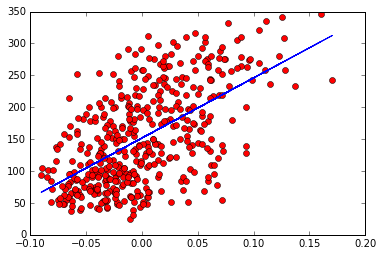

In [137]:
plt.plot(diabetes_X1,diabetes_Y,'ro')
plt.plot(diabetes_X1,test_lin_out)

In [38]:
if any([x.op.__class__.__name__ in ['GpuGemm','GpuGemv'] for x in train_lin.maker.fgraph.toposort()]):
    print("Used the gpu")
else:
    print(train_lin.maker.fgraph.toposort())

[Elemwise{Composite{(((i0 * i1) + i2) - i3)}}(thet1, x1, thet0, ylin), Elemwise{Composite{(i0 - (i1 * i2))}}[(0, 0)](thet0, TensorConstant{0.00999999977648}, Elemwise{Composite{(((i0 * i1) + i2) - i3)}}.0), Elemwise{Composite{(i0 - (i1 * i2 * i3))}}[(0, 0)](thet1, TensorConstant{0.00999999977648}, Elemwise{Composite{(((i0 * i1) + i2) - i3)}}.0, x1), Elemwise{Composite{(i0 * sqr(i1))}}[(0, 1)](TensorConstant{0.5}, Elemwise{Composite{(((i0 * i1) + i2) - i3)}}.0)]


In [39]:
if np.any([isinstance(x.op,T.Elemwise) for x in train_lin.maker.fgraph.toposort()]):
    print("Used the cpu")

Used the cpu


## Linear Algebra and `theano`

cf. [Week 1, Linear Algebra Review, Coursera, Machine Learning with Ng](https://www.coursera.org/learn/machine-learning/lecture/38jIT/matrices-and-vectors)

I'll take this opportunity to provide a dictionary between the syntax of linear algebra math and `numpy`.   

Essentially, what I did was take Coursera's [Week 1, Linear Algebra Review](https://www.coursera.org/learn/machine-learning/lecture/dpF1j/matrix-matrix-multiplication) and then translated the math into **`theano`**, and in particular, running theano on the **GPU**.

Other reference that I used was 

https://simplyml.com/linear-algebra-shootout-numpy-vs-theano-vs-tensorflow-2/

[Linear Algebra Shootout: NumPy vs. Theano vs. TensorFlow by Charanpal Dhanjal - 14/07/16 ](https://simplyml.com/linear-algebra-shootout-numpy-vs-theano-vs-tensorflow-2/)

#### Matrix addition

cf. [Coursera, Intro. to Machine Learning, Linear Algebra Review, Addition and Scalar Multiplication](https://www.coursera.org/learn/machine-learning/lecture/R4hiJ/addition-and-scalar-multiplication)

In [69]:
A = T.matrix('A')
B = T.matrix('B')
#matadd = function([A,B], A+B)
#matadd = function([A,B],sandbox.cuda.basic_ops.gpu_from_host(A+B) )
# Note: we are just defining the expressions, nothing is evaluated here!  
C = sandbox.cuda.basic_ops.gpu_from_host(A+B)
matadd = function([A,B], C)

In [121]:
#A = T.dmatrix('A')
#B = T.dmatrix('B')

A = T.matrix('A')
B = T.matrix('B')

C_out = A + B
matadd_CPU = function([A,B], C_out)

In [73]:
A_eg = shared( np.array([[8,6,9],[10,1,10]]), 'float32')
B_eg = shared( np.array([[3,10,2],[6,1,-1]]), 'float32')


In [85]:
A_eg_CPU = np.array([[8,6,9],[10,1,10]])
B_eg_CPU = np.array([[3,10,2],[6,1,-1]])

In [96]:
print(A_eg_CPU)
print( type( A_eg_CPU ))
print( A_eg_CPU.shape)
print( B_eg_CPU.shape)

[[ 8  6  9]
 [10  1 10]]
<type 'numpy.ndarray'>
(2, 3)
(2, 3)


In [70]:
print( matadd.maker.fgraph.toposort() )

[GpuFromHost(B), GpuFromHost(A), GpuElemwise{Add}[(0, 0)](GpuFromHost.0, GpuFromHost.0)]


In [122]:
print( matadd_CPU.maker.fgraph.toposort() )

[GpuFromHost(B), GpuFromHost(A), GpuElemwise{Add}[(0, 0)](GpuFromHost.0, GpuFromHost.0), HostFromGpu(GpuElemwise{Add}[(0, 0)].0)]


In [71]:
matadd( A_eg, B_eg)

TypeError: ('Bad input argument to theano function with name "<ipython-input-69-40293d053d65>:7"  at index 0(0-based)', 'Expected an array-like object, but found a Variable: maybe you are trying to call a function on a (possibly shared) variable instead of a numeric array?')

The way to do it, to "force" on the GPU, is like this (cf. [Speeding up your Neural Network with Theano and the GPU - Wild ML](http://www.wildml.com/2015/09/speeding-up-your-neural-network-with-theano-and-the-gpu/)):

In [76]:
np.random.randn( *A_eg_CPU.shape )

array([[ 1.01645633,  0.49394088, -0.22904526],
       [-0.44323914, -0.27948502,  0.335645  ]])

In [78]:
C_out = theano.shared( np.random.randn( *A_eg_CPU.shape).astype('float32') )

In [80]:
C_out.type()

<CudaNdarrayType(float32, matrix)>

In [110]:
#A_in = shared( A_eg_CPU, "float32")
#A_in = shared( A_eg_CPU, "float32")

A_in = shared( A_eg_CPU.astype("float32"), "float32")
B_in = shared( B_eg_CPU.astype("float32"), "float32")
#C_out_GPU = A_in + B_in
C_out_GPU = sandbox.cuda.basic_ops.gpu_from_host(A_in+B_in)


In [111]:
matadd_GPU = theano.function( [], C_out_GPU)

In [112]:
C_out_GPU_result = matadd_GPU()

In [113]:
C_out_GPU_result

CudaNdarray([[ 11.  16.  11.]
 [ 16.   2.   9.]])

Notice how **DIFFERENT** this setup or syntax is: we have to set up tensor or matrix *shared variables* `A_n`, `B_in`, which are then used to define the theano function, `theano.function`.  "By using shared variables we ensure that they are present in the GPU memory".  cf. [Linear Algebra Shootout: NumPy vs. Theano vs. TensorFlow](https://simplyml.com/linear-algebra-shootout-numpy-vs-theano-vs-tensorflow-2/)

In [114]:
print( matadd_GPU.maker.fgraph.toposort() )

[GpuElemwise{add,no_inplace}(float32, float32)]


In [128]:
#if np.any([isinstance(C_out_GPU.op, tensor.Elemwise ) and 
if np.any([isinstance( C_out_GPU.op, T.Elemwise ) and 
           ('Gpu' not in type( C_out_GPU.op).__name__) for x in matadd_GPU.maker.fgraph.toposort()]) :
    print('Used the cpu')
else:
    print('Used the gpu')

AttributeError: 'CudaNdarrayVariable' object has no attribute 'op'

In [124]:
matadd_CPU( A_eg_CPU.astype("float32"), B_eg_CPU.astype("float32") )

array([[ 11.,  16.,  11.],
       [ 16.,   2.,   9.]], dtype=float32)

In [55]:
type(A_eg)

theano.tensor.sharedvar.TensorSharedVariable

In [59]:
print( type( numpy.asarray(rng.rand(2000)) ) )
numpy.asarray(rng.rand(2000)).shape

<type 'numpy.ndarray'>


(2000,)

**Bottom Line:** there are **2** ways of doing linear algebra *on the GPU*

1. symbolic computation with the usual arguments    

$$
A + B = C \in \text{Mat}_{\mathbb{R}}(M,N)   
$$   

$ \forall \, A, B \in \text{Mat}_{\mathbb{R}}(M,N)$

In [132]:
A = T.matrix('A')
B = T.matrix('B')

C = sandbox.cuda.basic_ops.gpu_from_host( A + B ) # vs. 
# C = A + B  # this will result in an output array on the host, as opposed to CudaNdarray on device
matadd = function([A,B], C)

In [133]:
print( matadd.maker.fgraph.toposort() )

[GpuFromHost(B), GpuFromHost(A), GpuElemwise{Add}[(0, 0)](GpuFromHost.0, GpuFromHost.0)]


In [134]:
matadd( A_eg_CPU.astype("float32"), B_eg_CPU.astype("float32") )

CudaNdarray([[ 11.  16.  11.]
 [ 16.   2.   9.]])

2. with *shared variables*

In [140]:
A_in = shared( A_eg_CPU.astype("float32"), "float32")  # initialize with the input values, A_eg_CPU, anyway
B_in = shared( B_eg_CPU.astype("float32"), "float32")  # initialize with the input values B_eg_CPU, anyway

# C_out = A_in + B_in # this version will output to the host as a numpy.ndarray
# indeed, reading the graph,
"""
[GpuElemwise{add,no_inplace}(float32, float32), HostFromGpu(GpuElemwise{add,no_inplace}.0)]
"""
# this version immediately below, in 1 line, will result in a CudaNdarray on device
C_out = sandbox.cuda.basic_ops.gpu_from_host(A_in+B_in)

matadd_GPU = theano.function( [], C_out)

In [141]:
print( matadd_GPU.maker.fgraph.toposort() )

[GpuElemwise{add,no_inplace}(float32, float32)]


In [142]:
C_out_result = matadd_GPU()

In [143]:
C_out_result

CudaNdarray([[ 11.  16.  11.]
 [ 16.   2.   9.]])

### Scalar Multiplication (on the GPU)

cf. [Scalar Multiplication of Linear Algebra Review, coursera, Machine Learning Intro by Ng](https://www.coursera.org/learn/machine-learning/lecture/R4hiJ/addition-and-scalar-multiplication)

In [149]:
A_2 = np.array( [[4,5],[1,7] ])

In [145]:
a = T.scalar('a')

F = sandbox.cuda.basic_ops.gpu_from_host( a*A )
scalarmul = theano.function([a,A],F)

In [146]:
print( scalarmul.maker.fgraph.toposort() )

[GpuFromHost(A), GpuFromHost(a), GpuDimShuffle{x,x}(GpuFromHost.0), GpuElemwise{Mul}[(0, 1)](GpuDimShuffle{x,x}.0, GpuFromHost.0)]


In [150]:
scalarmul( np.float32( 2.), A_2.astype("float32"))

CudaNdarray([[  8.  10.]
 [  2.  14.]])

# Composition; Confirming that you can do composition of scalar multiplication on a matrix (or ring) addition

Being able to do composition is *very important* in math

In [152]:
scalarmul( np.float32(2.), matadd( A_eg_CPU.astype("float32"), B_eg_CPU.astype("float32") ) )

CudaNdarray([[ 22.  32.  22.]
 [ 32.   4.  18.]])

In [156]:
u = T.vector('u')
v = T.vector('v')

w = sandbox.cuda.basic_ops.gpu_from_host( u + v)
vecadd = theano.function( [u,v],w)

t = sandbox.cuda.basic_ops.gpu_from_host( a * u)
scalarmul_vec = theano.function([a,u], t)


In [157]:
print(vecadd.maker.fgraph.toposort())  
print(scalarmul_vec.maker.fgraph.toposort())  


[GpuFromHost(v), GpuFromHost(u), GpuElemwise{Add}[(0, 0)](GpuFromHost.0, GpuFromHost.0)]
[GpuFromHost(u), GpuFromHost(a), GpuDimShuffle{x}(GpuFromHost.0), GpuElemwise{Mul}[(0, 1)](GpuDimShuffle{x}.0, GpuFromHost.0)]


In [162]:
u_eg = np.array( [4,6,7], dtype="float32")
v_eg = np.array( [2,1,0], dtype="float32")

print( u_eg.shape)

(3,)


In [161]:
scalarmul_vec( np.float32(0.5), u_eg )

CudaNdarray([ 2.   3.   3.5])

In [163]:
vecadd( scalarmul_vec( np.float32(0.5), u_eg ) , scalarmul_vec( np.float32(-3.), v_eg )  )

CudaNdarray([-4.   0.   3.5])

This was the computer equivalent to mathematical expression:  

$$   
\left[ \begin{matrix} 4 \\ 6 \\ 7 \end{matrix} \right] /2 - 3 * \left[ \begin{matrix} 2 \\ 1 \\ 0 \end{matrix} \right]
$$   


### sAxy or A-V multiplication or so-called "Gemv", or Matrix Multiplication on a vector, or linear transformation on a R-module, or vector space   

i.e.   

$$
Av = B   
$$

In [164]:
B_out = sandbox.cuda.basic_ops.gpu_from_host( T.dot(A,v))
AVmul = theano.function([A,v], B_out)
print(AVmul.maker.fgraph.toposort())

[GpuFromHost(v), GpuFromHost(A), Shape_i{0}(A), GpuAllocEmpty(Shape_i{0}.0), GpuGemv{inplace}(GpuAllocEmpty.0, TensorConstant{1.0}, GpuFromHost.0, GpuFromHost.0, TensorConstant{0.0})]


In [165]:
AVmul( np.array([[1,0,3],[2,1,5],[3,1,2]]).astype("float32"), np.array([1,6,2]).astype("float32"))

CudaNdarray([  7.  18.  13.])

In [168]:
AVmul( np.array([[1,0,0],[0,1,0],[0,0,1]]).astype("float32"), np.array([1,6,2]).astype("float32"))

CudaNdarray([ 1.  6.  2.])

### AB or Gemm or Matrix Multiplication, i.e. Ring multiplication   

i.e.   
$$  
A*B = C  
$$

In [166]:
C_f = sandbox.cuda.basic_ops.gpu_from_host( T.dot(A,B)) 
matmul = theano.function([A,B], C_f)
print( matmul.maker.fgraph.toposort())

[GpuFromHost(B), GpuFromHost(A), GpuDot22(GpuFromHost.0, GpuFromHost.0)]


In [167]:
matmul( np.array( [[1,3],[2,4],[0,5]]  ).astype("float32"), np.array([[1,0],[2,3]]).astype("float32")  )

CudaNdarray([[  7.   9.]
 [ 10.  12.]
 [ 10.  15.]])

### Inverse and Transpose   

cf. [Inverse and Transpose](https://www.coursera.org/learn/machine-learning/lecture/FuSWY/inverse-and-transpose)

In [170]:
Ainverse = sandbox.cuda.basic_ops.gpu_from_host( T.inv(A))
Ainv = theano.function([A], Ainverse)
print(Ainv.maker.fgraph.toposort())

[GpuFromHost(A), GpuElemwise{Inv}[(0, 0)](GpuFromHost.0)]


In [172]:
Atranspose = sandbox.cuda.basic_ops.gpu_from_host( A.T)
AT = theano.function([A],Atranspose)
print(AT.maker.fgraph.toposort())

[GpuFromHost(A), GpuDimShuffle{1,0}(GpuFromHost.0)]


### Summation, sum, mean, scan

# Linear Regression (again), via Coursera's Machine Learning Intro by Ng, Programming Exercise 1 for Week 2

### Boilerplate, load sample data

In [9]:
linregdata = pd.read_csv('./coursera_Ng/machine-learning-ex1/ex1/ex1data1.txt', header=None)

In [11]:
X_linreg_training = linregdata.as_matrix([0])  # pandas.DataFrame.as_matrix convert frame to its numpy-array representation
y_linreg_training = linregdata.as_matrix([1])
m_linreg_training = len(y_linreg_training)  # number of training examples  
print( X_linreg_training.shape, type(X_linreg_training)) 
print( y_linreg_training.shape, type(y_linreg_training)) 
print m_linreg_training

((97, 1), <type 'numpy.ndarray'>)
((97, 1), <type 'numpy.ndarray'>)
97


Try representing $\theta$, parameters or "weights", of size $|\theta|$ which should be equal to the number of features $n$ (or $d$).  

In [109]:
# theta_linreg = T.vector('theta_linreg')
d = X_linreg_training.shape[1] # d = features

# Declare Theano symbolic variables
X = T.matrix('x')
y = T.vector('y')

Preprocess training data (due to numpy's treatment of arrays) (note, this is not needed, if you use pandas to choose which column(s) you want to make into a numpy array)

In [188]:
#X_linreg_training = X_linreg_training.reshape( m_linreg_training,1)
#y_linreg_training = y_linreg_training.reshape( m_linreg_training,1)

In [12]:
# Instead, the training data X and test data values y are going to be represented by Theano symbolic variable above
#X_linreg = theano.shared(X_linreg_training.astype("float32"),"float32")
#y_linreg = theano.shared(y_linreg_training.astype("float32"),"float32")

In [110]:
#theta_0 = np.zeros( ( d+1,1)); print(theta_0)
theta_0 = np.zeros(  d+1); print(theta_0)

[ 0.  0.]


In [111]:
theta = theano.shared( theta_0.astype("float32"), "theta")

In [89]:
alpha = np.float32(0.01) # learning rate gamma or alpha

In [112]:
# Construct Theano "expression graph"

predicted_vals = sandbox.cuda.basic_ops.gpu_from_host( T.dot(X,theta) )  # h_{\theta}
m = np.float32( y_linreg_training.shape[0] ) 
J_theta = sandbox.cuda.basic_ops.gpu_from_host( 
    T.dot( (T.dot(X,theta) - y).T, T.dot(X,theta) - y)  * np.float32( 0.5 ) * np.float32( 1./ m )   
    ) # cost function



In [113]:
update_theta = sandbox.cuda.basic_ops.gpu_from_host( 
        theta - alpha * T.grad( J_theta, theta) )


In [114]:
gradientDescent = theano.function( 
                            inputs=[X,y],
                            outputs=[predicted_vals,J_theta],  
                            updates=[(theta, update_theta)], 
                            name = "gradientDescent")


In [115]:
print( gradientDescent.maker.fgraph.toposort() )

[GpuFromHost(x), Shape_i{0}(x), GpuFromHost(y), GpuAllocEmpty(TensorConstant{1}), GpuDimShuffle{1,0}(GpuFromHost.0), GpuAllocEmpty(Shape_i{0}.0), GpuGemv{inplace}(GpuAllocEmpty.0, TensorConstant{1.0}, GpuFromHost.0, theta, TensorConstant{0.0}), GpuElemwise{Sub}[(0, 1)](GpuGemv{inplace}.0, GpuFromHost.0), GpuDimShuffle{0}(GpuElemwise{Sub}[(0, 1)].0), GpuDimShuffle{x,0}(GpuElemwise{Sub}[(0, 1)].0), GpuGemv{inplace}(GpuAllocEmpty.0, TensorConstant{1.0}, GpuDimShuffle{x,0}.0, GpuDimShuffle{0}.0, TensorConstant{0.0}), GpuElemwise{Mul}[(0, 1)](CudaNdarrayConstant{[ 0.00515464]}, GpuElemwise{Sub}[(0, 1)].0), GpuDimShuffle{}(GpuGemv{inplace}.0), GpuGemv{inplace}(theta, TensorConstant{-0.019999999553}, GpuDimShuffle{1,0}.0, GpuElemwise{Mul}[(0, 1)].0, TensorConstant{1.0}), GpuElemwise{Mul}[(0, 1)](CudaNdarrayConstant{0.00515463901684}, GpuDimShuffle{}.0)]


In [116]:
num_iters = 1500
J_History = []

Preprocess X to *include intercepts*

In [95]:
input_X_linreg = np.hstack( ( np.ones((m_linreg_training,1)), X_linreg_training ) ).astype("float32")

In [96]:
y_linreg_training_processed = y_linreg_training.reshape( m_linreg_training,).astype("float32")

In [117]:
J_History = [0 for iter in range(num_iters)]
for iter in range(num_iters):
    predicted_vals_out, J_out = \
        gradientDescent(input_X_linreg.astype("float32"), y_linreg_training_processed.astype("float32") ) 
    J_History[iter] = J_out

In [45]:
Deg = (np.random.randn(40,10).astype("float32"), np.random.randint(size=40,low=0,high=2).astype("float32") )

In [46]:
Deg[0].shape

(40, 10)

In [47]:
Deg[1].shape

(40,)

In [118]:
theta.get_value()

array([-3.63029242,  1.1663624 ], dtype=float32)

In [101]:
dir( J_History[0] )

['__add__',
 '__array__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__getitem__',
 '__hash__',
 '__iadd__',
 '__idiv__',
 '__init__',
 '__len__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_dev_data',
 '_set_shape_i',
 '_set_stride',
 '_strides',
 'base',
 'copy',
 'dtype',
 'exp',
 'gpudata',
 'is_c_contiguous',
 'mem_size',
 'ndim',
 'reduce_sum',
 'reshape',
 'shape',
 'size',
 'strides',
 'take',
 'view',
 'zeros']

In [121]:
J_History[-5].gpudata

47407335424

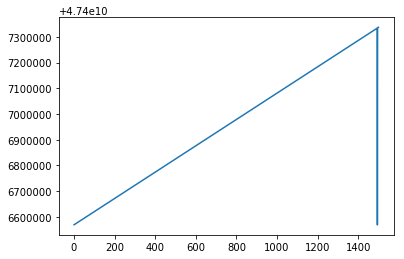

In [120]:
plt.plot( [ele.gpudata for ele in J_History])

Denny Britz's way:  

http://www.wildml.com/2015/09/speeding-up-your-neural-network-with-theano-and-the-gpu/

[Speeding up your Neural Network with Theano and the GPU](http://www.wildml.com/2015/09/speeding-up-your-neural-network-with-theano-and-the-gpu/)

and his jupyter notebook

https://github.com/dennybritz/nn-theano/blob/master/nn-theano-gpu.ipynb

[ `nn-theano/nn-theano-gpu.ipynb`](https://github.com/dennybritz/nn-theano/blob/master/nn-theano-gpu.ipynb)




In [73]:
input_X_linreg.shape

(97, 2)

In [122]:
# GPU NOTE: Conversion to float32 to store them on the GPU!
X = theano.shared( input_X_linreg.astype('float32'), name='X' )
y = theano.shared( y_linreg_training.astype('float32'), name='y')

In [123]:
# GPU NOTE: Conversion to float32 to store them on the GPU!  
theta = theano.shared( np.vstack(theta_0).astype("float32"), name='theta')

In [136]:
# Construct Theano "expression graph"

predicted_vals = sandbox.cuda.basic_ops.gpu_from_host( 
    T.dot(X,theta) )  # h_{\theta}
m = np.float32( y_linreg_training.shape[0] )
# cost function J_theta, J_{\theta}
J_theta = sandbox.cuda.basic_ops.gpu_from_host( 
    (
        T.dot( (T.dot(X,theta) - y).T, T.dot(X,theta) - y) * np.float32(0.5) * np.float32( 1./m)  
    ).reshape([]) )   # cost function  # reshape is to force "broadcast" into 0-dim. scalar for cost function
    


In [137]:
update_theta = sandbox.cuda.basic_ops.gpu_from_host( 
        theta - alpha * T.grad( J_theta, theta) )

In [138]:
# Note that we removed the input values because we will always use the same shared variable
# GPU Note: Removed the input values to avoid copying data to the GPU.
gradientDescent = theano.function( 
                            inputs=[],
#                            outputs=[predicted_vals,J_theta],  
                            updates=[(theta, update_theta)], 
                            name = "gradientDescent")


In [139]:
print( gradientDescent.maker.fgraph.toposort() )

[Shape_i{1}(theta), GpuDimShuffle{1,0}(X), GpuGemm{no_inplace}(y, TensorConstant{1.0}, X, theta, TensorConstant{-1.0}), MakeVector{dtype='int64'}(Shape_i{1}.0, Shape_i{1}.0), GpuReshape{2}(CudaNdarrayConstant{1.0}, MakeVector{dtype='int64'}.0), GpuElemwise{mul,no_inplace}(CudaNdarrayConstant{[[ 0.00515464]]}, GpuReshape{2}.0), GpuDot22(GpuGemm{no_inplace}.0, GpuElemwise{mul,no_inplace}.0), GpuDimShuffle{1,0}(GpuElemwise{mul,no_inplace}.0), GpuDot22(GpuGemm{no_inplace}.0, GpuDimShuffle{1,0}.0), GpuGemm{inplace}(theta, TensorConstant{-0.00999999977648}, GpuDimShuffle{1,0}.0, GpuDot22.0, TensorConstant{1.0}), GpuGemm{inplace}(GpuGemm{inplace}.0, TensorConstant{-0.00999999977648}, GpuDimShuffle{1,0}.0, GpuDot22.0, TensorConstant{1.0})]


In [141]:
#J_History = [0 for iter in range(num_iters)]
for iter in range(num_iters):
    gradientDescent( ) 
    

In [78]:
print( np.vstack( theta_0).shape )
print( y_linreg_training.shape )

(2, 1)
(97, 1)


In [149]:
theta.get_value()

array([[-3.63076854],
       [ 1.16641033]], dtype=float32)

In [152]:
# Profiling
print( theano.config.profile )  # Do the vm/cvm linkers profile the execution time of Theano functions?
print( theano.config.profile_memory ) # Do the vm/cvm linkers profile the memory usage of Theano functions? It only works when profile=True.

False
False


In [154]:
theano.printing.debugprint(gradientDescent)

GpuGemm{inplace} [id A] ''   10
 |GpuGemm{inplace} [id B] ''   9
 | |theta [id C]
 | |TensorConstant{-0.00999999977648} [id D]
 | |GpuDimShuffle{1,0} [id E] ''   1
 | | |X [id F]
 | |GpuDot22 [id G] ''   8
 | | |GpuGemm{no_inplace} [id H] ''   2
 | | | |y [id I]
 | | | |TensorConstant{1.0} [id J]
 | | | |X [id F]
 | | | |theta [id C]
 | | | |TensorConstant{-1.0} [id K]
 | | |GpuDimShuffle{1,0} [id L] ''   7
 | |   |GpuElemwise{mul,no_inplace} [id M] ''   5
 | |     |CudaNdarrayConstant{[[ 0.00515464]]} [id N]
 | |     |GpuReshape{2} [id O] ''   4
 | |       |CudaNdarrayConstant{1.0} [id P]
 | |       |MakeVector{dtype='int64'} [id Q] ''   3
 | |         |Shape_i{1} [id R] ''   0
 | |         | |theta [id C]
 | |         |Shape_i{1} [id R] ''   0
 | |TensorConstant{1.0} [id J]
 |TensorConstant{-0.00999999977648} [id D]
 |GpuDimShuffle{1,0} [id E] ''   1
 |GpuDot22 [id S] ''   6
 | |GpuGemm{no_inplace} [id H] ''   2
 | |GpuElemwise{mul,no_inplace} [id M] ''   5
 |TensorConstant{1.0} [id 

In [157]:
#print( gradientDescent.profile.print_summary() )
dir( gradientDescent.profile)

['__class__',
 '__delattr__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

## Testing the Linear Regression with (Batch) Gradient Descent classes in `./ML/`

In [9]:
import sys
import os

In [10]:
#sys.path.append( os.getcwd() + '/ML')
sys.path.append( os.getcwd() + '/ML' )

In [10]:
from linreg_gradDes import LinearReg, LinearReg_loaded
#from ML import LinearReg, LinearReg_loaded

**Boilerplate** for sample input data

In [11]:
linregdata1 = pd.read_csv('./coursera_Ng/machine-learning-ex1/ex1/ex1data1.txt', header=None)
linregdata1.as_matrix([0]).shape
linregdata1.as_matrix([1]).shape

(97, 1)

In [12]:
features = linregdata1.as_matrix([0]).shape[1]
numberoftraining = linregdata1.as_matrix([0]).shape[0]
LinReg_housing = LinearReg( features, numberoftraining , 0.01)

In [13]:
Xin   = LinReg_housing.preprocess_X( linregdata1.as_matrix([0]))
ytest = linregdata1.as_matrix([1]).flatten()

In [14]:
%time LinReg_housing.build_model( Xin, ytest )

CPU times: user 171 ms, sys: 28.9 ms, total: 200 ms
Wall time: 198 ms


array([-3.63029242,  1.1663624 ], dtype=float32)

In [19]:
LinRegloaded_housing = LinearReg_loaded( linregdata1.as_matrix([0]), linregdata1.as_matrix([1]), 
                                        features, numberoftraining )

In [20]:
%time LinRegloaded_housing.build_model()

CPU times: user 136 ms, sys: 16.4 ms, total: 152 ms
Wall time: 132 ms


array([[-3.63028979],
       [ 1.16636217]], dtype=float32)

In [53]:
print( LinReg_housing.gradientDescent.maker.fgraph.toposort() )
print( LinRegloaded_housing.gradientDescent.maker.fgraph.toposort() )


[GpuFromHost(X), Shape_i{0}(X), GpuFromHost(y), GpuAllocEmpty(TensorConstant{1}), GpuDimShuffle{1,0}(GpuFromHost.0), GpuAllocEmpty(Shape_i{0}.0), GpuGemv{inplace}(GpuAllocEmpty.0, TensorConstant{1.0}, GpuFromHost.0, theta, TensorConstant{0.0}), GpuElemwise{Sub}[(0, 1)](GpuGemv{inplace}.0, GpuFromHost.0), GpuDimShuffle{0}(GpuElemwise{Sub}[(0, 1)].0), GpuDimShuffle{x,0}(GpuElemwise{Sub}[(0, 1)].0), GpuGemv{inplace}(GpuAllocEmpty.0, TensorConstant{1.0}, GpuDimShuffle{x,0}.0, GpuDimShuffle{0}.0, TensorConstant{0.0}), GpuElemwise{Mul}[(0, 1)](CudaNdarrayConstant{[ 0.00515464]}, GpuElemwise{Sub}[(0, 1)].0), GpuDimShuffle{}(GpuGemv{inplace}.0), GpuGemv{inplace}(theta, TensorConstant{-0.019999999553}, GpuDimShuffle{1,0}.0, GpuElemwise{Mul}[(0, 1)].0, TensorConstant{1.0}), GpuElemwise{Mul}[(0, 1)](CudaNdarrayConstant{0.00515463901684}, GpuDimShuffle{}.0)]
[Shape_i{1}(theta), GpuDimShuffle{1,0}(X), GpuGemm{no_inplace}(y, TensorConstant{1.0}, X, theta, TensorConstant{-1.0}), MakeVector{dtype='int

#### Other (sample) datasets

Consider *feature normalization*

In [40]:
def featureNormalize(X):
    """
    FEATURENORMALIZE Normalizes the features in X  
    FEATURENORMALIZE(X) returns a normalized version of X where  
    the mean value of each feature is 0 and the standard deviation  
    is 1.  This is often a good preprocessing step to do when 
    working with learning algorithms.
    
    """
    # You need to set these values correctly  
    X_norm = (X-X.mean(axis=0))/X.std(axis=0)
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    
    return [X_norm, mu, sigma]

In [41]:
linregdata2 = pd.read_csv('./coursera_Ng/machine-learning-ex1/ex1/ex1data2.txt', header=None)


In [42]:
features = linregdata2.as_matrix().shape[1] - 1
numberoftraining = linregdata2.as_matrix().shape[0]
Xdat  = linregdata2.as_matrix( range(features) )
ytest = linregdata2.as_matrix( [features])

In [46]:
[Xnorm, mus,sigmas] = featureNormalize(Xdat)

In [48]:
LinReg_housing2 = LinearReg( features, numberoftraining, 0.01)
processed_X = LinReg_housing2.preprocess_X( Xnorm )

In [49]:
%time LinReg_housing2.build_model( processed_X, ytest.flatten(), 400)

CPU times: user 59.1 ms, sys: 8.88 ms, total: 67.9 ms
Wall time: 66.2 ms


array([ 334302.125    ,   99411.4609375,    3267.0065918], dtype=float32)

In [50]:
LinRegloaded_housing2 = LinearReg_loaded( Xnorm, ytest, 
                                        features, numberoftraining )

In [51]:
%time LinRegloaded_housing2.build_model(  400)

CPU times: user 48.9 ms, sys: 2.49 ms, total: 51.3 ms
Wall time: 45.4 ms


array([[ 334302.21875   ],
       [  99411.453125  ],
       [   3267.00976562]], dtype=float32)

##### Diabetes data from `sklearn`, sci-kit learn

In [54]:
# Load the diabetes dataset
diabetes = sklearn.datasets.load_diabetes()

In [55]:
diabetes_X = diabetes.data
diabetes_Y = diabetes.target

In [61]:
#diabetes_X1 = diabetes_X[:,np.newaxis,2]
diabetes_X1 = diabetes_X[:,np.newaxis, 2].astype(theano.config.floatX)
#diabetes_Y  = diabetes_Y.reshape( diabetes_Y.shape[0], 1)
diabetes_Y = np.vstack( diabetes_Y.astype(theano.config.floatX) )

In [63]:
features1 = 1 
numberoftraining = diabetes_Y.shape[0]

In [67]:
LinReg_diabetes = LinearReg( features1, numberoftraining, 0.01)


In [70]:
processed_X = LinReg_diabetes.preprocess_X( diabetes_X1 )

In [71]:
%time LinReg_diabetes.build_model( processed_X, diabetes_Y.flatten(), 10000)

CPU times: user 753 ms, sys: 118 ms, total: 871 ms
Wall time: 867 ms


array([ 152.13273621,  192.24055481], dtype=float32)

In [74]:
LinRegloaded_diabetes = LinearReg_loaded( diabetes_X1, diabetes_Y, 
                                        features1, numberoftraining )

In [75]:
%time LinRegloaded_diabetes.build_model(  10000)

CPU times: user 707 ms, sys: 45.2 ms, total: 752 ms
Wall time: 718 ms


array([[ 152.13198853],
       [ 192.2406311 ]], dtype=float32)

Multiple number of features case:

In [76]:
features = diabetes_X.shape[1]


In [77]:
LinReg_diabetes = LinearReg( features, numberoftraining, 0.01)
processed_X = LinReg_diabetes.preprocess_X( diabetes_X )

In [78]:
%time LinReg_diabetes.build_model( processed_X, diabetes_Y.flatten(), 10000)

CPU times: user 855 ms, sys: 113 ms, total: 968 ms
Wall time: 964 ms


array([ 152.13273621,   40.02508163,   -5.81352949,  162.25823975,
        117.35097504,   38.3995285 ,   24.88706589, -100.40937042,
         99.55418396,  149.29826355,   92.1962738 ], dtype=float32)

In [79]:
LinRegloaded_diabetes = LinearReg_loaded( diabetes_X, diabetes_Y, 
                                        features, numberoftraining )

In [80]:
%time LinRegloaded_diabetes.build_model(  10000)

CPU times: user 702 ms, sys: 64.4 ms, total: 766 ms
Wall time: 728 ms


array([[ 152.13198853],
       [  40.02506256],
       [  -5.81354237],
       [ 162.25799561],
       [ 117.35108948],
       [  38.39954376],
       [  24.88703156],
       [-100.40942383],
       [  99.55430603],
       [ 149.29826355],
       [  92.1962738 ]], dtype=float32)

## `ex2` Linear Regression, on d=2 features

In [5]:
data_ex1data2 = pd.read_csv('./coursera_Ng/machine-learning-ex1/ex1/ex1data2.txt', header=None)
X_ex1data2 = data_ex1data2.iloc[:,0:2]
y_ex1data2 = data_ex1data2.iloc[:,2]
m_ex1data2 = y_ex1data2.shape[0]
X_ex1data2=X_ex1data2.values.astype(np.float32)
y_ex1data2=y_ex1data2.values.reshape((m_ex1data2,1)).astype(np.float32)
print(type(X_ex1data2))
print(type(y_ex1data2))
print(X_ex1data2.shape)
print(y_ex1data2.shape)
print(m_ex1data2)
print(X_ex1data2[:5])
print(y_ex1data2[:5])

<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
(47, 2)
(47, 1)
47
[[  2.10400000e+03   3.00000000e+00]
 [  1.60000000e+03   3.00000000e+00]
 [  2.40000000e+03   3.00000000e+00]
 [  1.41600000e+03   2.00000000e+00]
 [  3.00000000e+03   4.00000000e+00]]
[[ 399900.]
 [ 329900.]
 [ 369000.]
 [ 232000.]
 [ 539900.]]


In [46]:
((X_ex1data2[:,1] - X_ex1data2[:,1].mean())/( X_ex1data2[:,1].std()) ).std()

0.99999988

In [49]:
# feature Normalize
#X_ex1data2_norm = sklearn.preprocessing.Normalizer.transform(X_ex1data2 )
X_ex1data2_norm = (X_ex1data2  - np.mean(X_ex1data2, axis=0)) / np.std(X_ex1data2, axis=0)
print(X_ex1data2_norm[:,0].mean())
print(X_ex1data2_norm[:,0].std())
print(X_ex1data2_norm[:,1].mean())
print(X_ex1data2_norm[:,1].std())

-7.10183e-08
1.0
2.69489e-08
1.0


In [51]:
# X_ex1data2_norm[:5];

In [61]:
X=T.matrix(dtype=theano.config.floatX)
y=T.matrix(dtype=theano.config.floatX)

Theta=theano.shared(np.zeros((2,1)).astype(theano.config.floatX))
b = theano.shared(np.zeros(1).astype(theano.config.floatX))

In [16]:
print(b.get_value().shape)

(1,)


In [62]:
yhat = T.dot( X, Theta) + b

In [63]:
# L2 norm
J = np.cast[theano.config.floatX](0.5)*T.mean( T.sqr( yhat-y))

In [64]:
alpha=0.01  # learning rate
# sandbox.cuda.basic_ops.gpu_from_host
updateThetab = [ Theta-np.float32(alpha)*T.grad(J,Theta), b-np.float32(alpha)*T.grad(J,b)]
gradientDescent_step = theano.function(inputs=[X,y], 
                                          outputs=J,
                                          updates = zip([Theta,b],updateThetab) )


In [66]:
num_iters =400
JList=[]
for iter in range(num_iters):
    err = gradientDescent_step(X_ex1data2_norm,y_ex1data2)
    JList.append(err)

In [67]:
# Final mode:
print(Theta.get_value())
print(b.get_value())

[[ 99411.44601356]
 [  3267.01771421]]
[ 334302.0699632]


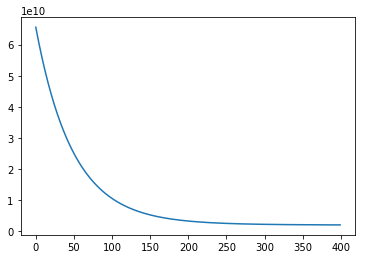

In [72]:
# JList[-10:]
plt.plot(JList)
plt.show()

# Multi-class Classification 

cf. `ex3`, Programming Exercise 3: Multi-class Classification and Neural Networks, Machine Learning

## 1 Multi-class Classification

In [83]:
os.getcwd()

'/home/topolo/PropD/MLgrabbag'

In [86]:
os.listdir( './coursera_Ng/machine-learning-ex3/' )

['ex3.pdf', 'ex3']

In [87]:
os.listdir( './coursera_Ng/machine-learning-ex3/ex3' )

['ex3data1.mat',
 'submit.m',
 'sigmoid.m',
 'lrCostFunction.m',
 'predictOneVsAll.m',
 'oneVsAll.m',
 'predict.m',
 'ex3.m',
 'lib',
 'displayData.m',
 'ex3_nn.m',
 'fmincg.m',
 'ex3weights.mat']

In [90]:
# Load saved matrices from file 
multiclscls_data = scipy.io.loadmat('./coursera_Ng/machine-learning-ex3/ex3/ex3data1.mat')

import the classes from `ML`


In [9]:
import sys
import os

In [9]:
os.getcwd()

'/home/topolo/PropD/MLgrabbag'

In [10]:
#sys.path.append( os.getcwd() + '/ML')
sys.path.append( os.getcwd() + '/ML' )

In [11]:
from gradDes import LogReg

In [12]:
# Test case for Cost function J_{\theta} with regularization

theta_t = np.vstack( np.array( [-2, -1, 1, 2]) )
X_t = np.array( [i/10. for i in range(1,16)]).reshape((3,5)).T
#X_t = np.hstack( ( np.ones((5,1)), X_t) ) # no need to preprocess the input data X with column of 1's
y_t = np.vstack( np.array( [1,0,1,0,1]))


In [13]:
MulClsCls_digits = LogReg( X_t, y_t, 3,5,0.01, 3.  )

In [14]:
MulClsCls_digits.calculate_cost()

CudaNdarray(0.125)

In [19]:
MulClsCls_digits.z.get_value()

AttributeError: 'CudaNdarrayVariable' object has no attribute 'get_value'

In [21]:
print( MulClsCls_digits.X.get_value() )
MulClsCls_digits.y.get_value()

[[ 1.          0.1         0.60000002  1.10000002]
 [ 1.          0.2         0.69999999  1.20000005]
 [ 1.          0.30000001  0.80000001  1.29999995]
 [ 1.          0.40000001  0.89999998  1.39999998]
 [ 1.          0.5         1.          1.5       ]]


array([[ 1.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 1.]], dtype=float32)

In [23]:
calc_z_test = theano.function([], MulClsCls_digits.z)

In [24]:
calc_z_test()

CudaNdarray([[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]])

In [25]:
MulClsCls_digits.theta.set_value( theta_t.astype('float32') )

In [27]:
calc_z_test()

CudaNdarray([[ 0.70000017]
 [ 0.9000001 ]
 [ 1.0999999 ]
 [ 1.29999983]
 [ 1.5       ]])

In [35]:
MulClsCls_digits.calculate_cost()

CudaNdarray(1.93287348747)

In [43]:
print( 1/(1+np.exp( np.dot( -np.hstack( ( np.ones((5,1)), X_t) ), theta_t) ) )  )
h_test = 1/(1+np.exp( np.dot( -np.hstack( ( np.ones((5,1)), X_t) ), theta_t) ) ) 
print( np.dot( (h_test - y_t).T, h_test- y_t) * 0.5/5 ) # non-regularized J_theta cost term
np.dot( theta_t[1:].T, theta_t[1:]) * 3 / (2.* 5)


[[ 0.66818777]
 [ 0.7109495 ]
 [ 0.75026011]
 [ 0.78583498]
 [ 0.81757448]]
[[ 0.13287343]]


array([[ 1.8]])

In [33]:
MulClsCls_digits.predict()

array([[ 0.66818786],
       [ 0.71094954],
       [ 0.75026011],
       [ 0.78583503],
       [ 0.81757444]], dtype=float32)

In [ ]:
MulClsCls_digit

In [44]:
theano.config.floatX

'float32'

# Neural Networks

## Model representation

cf. 2 Neural Networks, 2.1 Model representation, `ex3.pdf`

In [45]:
os.getcwd()

'/home/topolo/PropD/MLgrabbag'

In [46]:
os.listdir( './coursera_Ng/machine-learning-ex3/' )

['ex3.pdf', 'ex3']

In [47]:
os.listdir( './coursera_Ng/machine-learning-ex3/ex3/' )

['ex3data1.mat',
 'submit.m',
 'sigmoid.m',
 'token.mat',
 'lrCostFunction.m',
 'predictOneVsAll.m',
 'oneVsAll.m',
 'predict.m',
 'ex3.m',
 'lib',
 'displayData.m',
 'ex3_nn.m',
 'fmincg.m',
 'ex3weights.mat']

$ \Theta_1, \Theta_2 $

In [48]:
# Load saved matrices from file 
nn3_data = scipy.io.loadmat('./coursera_Ng/machine-learning-ex3/ex3/ex3weights.mat')

In [53]:
print( nn3_data.keys() )
print( type( nn3_data['Theta1']) )
print( type( nn3_data['Theta2']) )
print( nn3_data['Theta1'].shape )
print( nn3_data['Theta2'].shape )

['Theta2', '__version__', '__header__', 'Theta1', '__globals__']
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
(25, 401)
(10, 26)


In [54]:
Theta1[0]

NameError: name 'Theta1' is not defined

## Feedforward

In [61]:
%load_ext tikzmagic

ImportError: No module named tikzmagic

$$  
\begin{tikzpicture}
  \matrix (m) [matrix of math nodes, row sep=3em, column sep=4em, minimum width=2em]
  {
    \mathbb{R}^{s_l}  &  \mathbb{R}^{ s_l +1 }   & \mathbb{R}^{s_{l+1} } & \mathbb{R}^{s_{l+1} }  \\
a^{(l)} & (a_0^{(l)} = 1, a^{(l)} ) & z^{(l+1)} & g(z^{(l+1)}) = a^{(l+1)} \\
  };
  \path[->]
  (m-1-1) edge node [above] {$a_0^{(l)}=1$} (m-1-2)
  (m-1-2) edge node [above] {$\Theta^{(l)}$} (m-1-3)
  (m-1-3) edge node [above] {$g$} (m-1-4) 
  ;
  \path[|->]
  (m-2-1) edge node [above] {$a_0^{(l)}=1$} (m-2-2)
  (m-2-2) edge node [above] {$\Theta^{(l)}$} (m-2-3)
  (m-2-3) edge node [above] {$g$} (m-2-4) 
  ;
\end{tikzpicture}  
$$

In [66]:
np.random.seed(0)
s_l = 400 # (layer) size of layer l, i.e. number of nodes, units in layer l
s_lp1 = 25
al = theano.shared( np.random.randn(s_l+1,1).astype('float32'), name="al")
#alp1 = theano.shared( np.random.randn(s_lp1,1).astype('float32'), name="al")
#Thetal = theano.shared( np.random.randn( s_lp1,s_l+1).astype('float32') , name="Thetal")

# Feedforward, forward propagation
#z = T.dot( Thetal, al)
#g = T.nnet.sigmoid( z)


RuntimeError: Cuda error 'unspecified launch failure' while copying %lli data element to device memory

In [8]:
s_l = 25
s_lp1 = 10




In [19]:
rng = np.random.RandomState(99)
Theta_values = np.asarray( rng.uniform( 
    low=-np.sqrt( 6. / (s_l+ s_lp1)), 
    high=np.sqrt( 6./(s_l + s_lp1)), size=(s_lp1,s_l+1)), dtype=theano.config.floatX )
print( Theta_values.shape )
print( Theta_values.dtype )
#Theta_values *= np.float32(4)
Theta_values *= 4.

print( Theta_values.dtype)
Theta_values.shape

(10, 26)
float32
float32


(10, 26)

In [14]:
np.float32( 4)

(10, 26)

#### From Deep Learning Tutorials of LISA lab of University of Montreal; `logistic_sgd.py`, `mlp.py`

In [8]:
%env

{'BASH_FUNC_module()': '() {  eval `/usr/bin/modulecmd bash $*`\n}',
 'BASH_FUNC_scl()': '() {  local CMD=$1;\n if [ "$CMD" = "load" -o "$CMD" = "unload" ]; then\n eval "module $@";\n else\n /usr/bin/scl "$@";\n fi\n}',
 'CLICOLOR': '1',
 'CVS_RSH': 'ssh',
 'DBUS_SESSION_BUS_ADDRESS': 'unix:abstract=/tmp/dbus-N7ppIfAX8e,guid=e833f00fdfe69074bad66b6a58a4c651',
 'DESKTOP_SESSION': 'gnome',
 'DISPLAY': ':1',
 'GDMSESSION': 'gnome',
 'GDM_LANG': 'en_US.UTF-8',
 'GIT_PAGER': 'cat',
 'GJS_DEBUG_OUTPUT': 'stderr',
 'GJS_DEBUG_TOPICS': 'JS ERROR;JS LOG',
 'GNOME_DESKTOP_SESSION_ID': 'this-is-deprecated',
 'HISTCONTROL': 'ignoredups',
 'HISTSIZE': '1000',
 'HOME': '/home/topolo',
 'HOSTNAME': 'localhost.localdomain',
 'JPY_PARENT_PID': '3902',
 'LANG': 'en_US.UTF-8',
 'LD_LIBRARY_PATH': '/usr/local/lib:/usr/local/lib::/usr/local/cuda/lib64:/usr/local/lib64:/usr/local/cuda/lib64:/usr/local/lib64',
 'LESSOPEN': '||/usr/bin/lesspipe.sh %s',
 'LOADEDMODULES': '',
 'LOGNAME': 'topolo',
 'LS_COLORS':

In [10]:
os.getcwd()

'/home/topolo/PropD/MLgrabbag'

In [11]:
print( sys.path )

['', '/home/topolo/Public/anaconda2/lib/python2.7/site-packages/thermopy-0.5.4-py2.7.egg', '/home/topolo/Public/anaconda2/lib/python2.7/site-packages/pytools-2016.2.6-py2.7.egg', '/home/topolo/Public/anaconda2/lib/python2.7/site-packages/appdirs-1.4.0-py2.7.egg', '/home/topolo/Public/anaconda2/lib/python27.zip', '/home/topolo/Public/anaconda2/lib/python2.7', '/home/topolo/Public/anaconda2/lib/python2.7/plat-linux2', '/home/topolo/Public/anaconda2/lib/python2.7/lib-tk', '/home/topolo/Public/anaconda2/lib/python2.7/lib-old', '/home/topolo/Public/anaconda2/lib/python2.7/lib-dynload', '/home/topolo/Public/anaconda2/lib/python2.7/site-packages/PyDispatcher-2.0.5-py2.7.egg', '/home/topolo/Public/anaconda2/lib/python2.7/site-packages/Sphinx-1.3.5-py2.7.egg', '/home/topolo/Public/anaconda2/lib/python2.7/site-packages/characteristic-14.3.0-py2.7.egg', '/home/topolo/Public/anaconda2/lib/python2.7/site-packages/cssselect-0.9.1-py2.7.egg', '/home/topolo/Public/anaconda2/lib/python2.7/site-packages

In [12]:
#sys.path.append( os.getcwd() + '/ML')
sys.path.append( '../DeepLearningTutorials/code/' )

In [14]:
#from logistic_sgd import LogisticRegression, load_data, sgd_optimization_mnist, predict
import logistic_sgd 

In [10]:
MNIST_MTLdat = logistic_sgd.load_data("../DeepLearningTutorials/data/mnist.pkl.gz") # list of training data

NameError: name 'logistic_sgd' is not defined

In [36]:
print(len(MNIST_MTLdat))
print(type(MNIST_MTLdat))
for ele in MNIST_MTLdat: print type(ele), len(ele) # test_set_x, test_set_y, valid_set_x, valid_set_y, train_set_x, 

3
<type 'list'>
<type 'tuple'> 2
<type 'tuple'> 2
<type 'tuple'> 2


In [37]:
print( MNIST_MTLdat[0][0].get_value().shape)
print( type(MNIST_MTLdat[0][1]))
print( MNIST_MTLdat[0][1].get_scalar_constant_value )

(50000, 784)
<class 'theano.tensor.var.TensorVariable'>
<bound method TensorVariable.get_scalar_constant_value of Elemwise{Cast{int32}}.0>


In [38]:
print( type( MNIST_MTLdat[1][1] ) )
MNIST_MTLdat[1][1].shape

<class 'theano.tensor.var.TensorVariable'>


Shape.0

In [39]:
dir(MNIST_MTLdat[0][1]) ;

In [25]:
import gzip
import six.moves.cPickle as pickle
with gzip.open("../DeepLearningTutorials/data/mnist.pkl.gz", 'rb') as f:
    try:
        train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    except:
        train_set, valid_set, test_set = pickle.load(f)

In [26]:
print( type( train_set[0] ))
print( train_set[0].shape )
print( type( train_set[1]))
print( train_set[1].shape )
print( type( valid_set[0] ))
print( valid_set[0].shape )
print( type( valid_set[1]))
print( valid_set[1].shape )
print( type( test_set[0] ))
print( test_set[0].shape )
print( type( test_set[1]))
print( test_set[1].shape )


<type 'numpy.ndarray'>
(50000, 784)
<type 'numpy.ndarray'>
(50000,)
<type 'numpy.ndarray'>
(10000, 784)
<type 'numpy.ndarray'>
(10000,)
<type 'numpy.ndarray'>
(10000, 784)
<type 'numpy.ndarray'>
(10000,)


In [15]:
X = train_set[0].T

In [17]:
pd.DataFrame(X.T).describe()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000739,0.000354,0.000204,0.000090,0.000071,0.000009,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022778,0.015422,0.012079,0.007217,0.007181,0.001483,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.992188,0.992188,0.988281,0.988281,0.992188,0.242188,0.0,0.0,0.0,0.0


In [18]:
28*28

784

In [94]:
X_i = theano.shared( X.astype("float32"))

In [95]:
m = X_i.get_value().shape[1]

In [45]:
a1 = T.stack( [ theano.shared( np.ones((1,m)).astype("float32") ) , X_i ] , axis=1 )

In [41]:
print( type(a1) )
#print( a1.get_scalar_constant_value() )
dir(a1)
a1.get_parents()

<class 'theano.tensor.var.TensorVariable'>


[Join(TensorConstant{2}, DimShuffle{0,1,x}.0, DimShuffle{0,1,x}.0)]

In [46]:
a1.ndim

3

In [96]:
a1_0 = theano.shared( np.ones((1,m)).astype("float32"),name='a1_0')


In [97]:
a1 = T.stack( [a1_0,X_i], axis=0)

In [98]:
d = X_i.get_value().shape[0]
s_2 = d/2
rng1 = np.random.RandomState(1234)
Theta1_values = np.asarray( rng1.uniform( low=-np.sqrt(6./(d+s_2)),high=np.sqrt(6./(d+s_2)),size=(s_2,d+1)),
                           dtype=theano.config.floatX)
Theta1 = theano.shared(value=Theta1_values, name="Theta",borrow=True)

In [99]:
#rng1.uniform( low=-np.sqrt(6./(d+s_2)),high=np.sqrt(6./(d+s_2)),size=(s_2,d+1))
z1 = T.dot( Theta1, a1)
a2 = T.tanh(z1)

In [100]:
passthru1 = theano.function( [], a2)

In [101]:
print(d)
passthru1()

784


ValueError: GpuJoin: Wrong inputs for input 0 related to inputs 0.!
Apply node that caused the error: GpuJoin(TensorConstant{2}, GpuDimShuffle{0,1,x}.0, GpuDimShuffle{0,1,x}.0)
Toposort index: 9
Inputs types: [TensorType(int8, scalar), CudaNdarrayType(float32, (False, False, True)), CudaNdarrayType(float32, (False, False, True))]
Inputs shapes: [(), (1, 50000, 1), (784, 50000, 1)]
Inputs strides: [(), (0, 1, 0), (50000, 1, 0)]
Inputs values: [array(2, dtype=int8), 'not shown', 'not shown']
Outputs clients: [[GpuDimShuffle{1,0,2}(GpuJoin.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [108]:
print(X.shape)
X_i = theano.shared( X.astype("float32"))
#m = X_i.get_value().shape[1]
m = X.shape[1]
print(m)
a1_0 = theano.shared( np.ones((1,m)).astype("float32"),name='a1_0')
print(a1_0.get_value().shape)
a1 = T.stack( [a1_0,X_i], axis=0)
addintercept = theano.function([],a1)

(784, 50000)
50000
(1, 50000)


In [109]:
addintercept()

ValueError: GpuJoin: Wrong inputs for input 1 related to inputs 0.!
Apply node that caused the error: GpuJoin(TensorConstant{0}, GpuDimShuffle{x,0,1}.0, GpuDimShuffle{x,0,1}.0)
Toposort index: 2
Inputs types: [TensorType(int8, scalar), CudaNdarrayType(float32, (True, False, False)), CudaNdarrayType(float32, (True, False, False))]
Inputs shapes: [(), (1, 1, 50000), (1, 784, 50000)]
Inputs strides: [(), (0, 0, 1), (0, 50000, 1)]
Inputs values: [array(0, dtype=int8), 'not shown', 'not shown']
Outputs clients: [[HostFromGpu(GpuJoin.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [131]:
d = X_i.get_value().shape[0]
print(d)
s_2 = d/2
print(s_2)
rng1 = np.random.RandomState(1234)
Theta1_values = np.asarray( rng1.uniform( low=-np.sqrt(6./(d+s_2)),high=np.sqrt(6./(d+s_2)),size=(s_2,d)),
                           dtype=theano.config.floatX)
Theta1 = theano.shared(value=Theta1_values, name="Theta1",borrow=True)
b_values = np.vstack( np.zeros(s_2) ).astype(theano.config.floatX)
b1 = theano.shared(value=b_values, name='b1',borrow=True)
a1_values=np.array( np.zeros( (d,m)), dtype=theano.config.floatX)
a1 = theano.shared(value=a1_values, name='a1', borrow=True)
lin_z2 = T.dot( Theta1, a1) + T.tile(b1,(1,m))
#lin_z2 = T.dot( Theta1, a1)

784
392


In [132]:
test_mult = theano.function([],lin_z2)

print( type(b_values))
b_values.dtype


<type 'numpy.ndarray'>


dtype('float32')

In [133]:
test_mult()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [126]:
print( b1.get_value().shape )
T.tile( b1, (0,m))

(392, 1)


Reshape{2}.0

### `NN.py`, load `NN.py` for `Layer` class for Neural Net for Multiple Layers

In [13]:
import sys
import os

In [14]:
#sys.path.append( os.getcwd() + '/ML')
sys.path.append( os.getcwd() + '/ML' )

In [11]:
from NN import Layer, cost_functional, cost_functional_noreg, gradientDescent_step


Boilerplate sample data, from Coursera's *Machine Learning Introduction*

In [12]:
# Load Training Data
print("Loading and Visualizing Data ... \n")
ex4data1 = scipy.io.loadmat('./coursera_Ng/machine-learning-ex4/ex4/ex4data1.mat')

Loading and Visualizing Data ... 



In [14]:
ex4data1.keys()

['y', 'X', '__version__', '__header__', '__globals__']

In [16]:
print( ex4data1['X'].shape )
print( ex4data1['y'].shape )

(5000, 400)
(5000, 1)


In [13]:
test_rng = np.random.RandomState(1234)
#Theta1 = Layer( test_rng, 1, 400,25, 5000)

In [29]:
#help(Theta1.al.set_value); # Beginning with Theano 0.3.1, set_value will work in-place on the GPU, if ... source on CPU
Theta1.al.set_value( ex4data1['X'].T.astype(theano.config.floatX))

In [21]:
Theta1.alp1

Elemwise{tanh,no_inplace}.0

In [30]:
print( type( Theta1.alp1 ) )
Theta2 = Layer( test_rng, 2, 25,10,5000, al=Theta1.alp1 )

<class 'theano.tensor.var.TensorVariable'>


In [24]:
Theta2.alp1

Elemwise{tanh,no_inplace}.0

In [35]:
predicted = theano.function([],sandbox.cuda.basic_ops.gpu_from_host( Theta2.alp1 ) )

In [37]:
predicted().shape

(10, 5000)

In [39]:
print( ex4data1['y'].shape )
pd.DataFrame( ex4data1['y']).describe()

(5000, 1)


,0
count,5000.000000
mean,5.500000
std,2.872569
min,1.000000
25%,3.000000
50%,5.500000
75%,8.000000
max,10.000000


In [21]:
# recall that whereas the original labels (in the variable y) were 1, 2, ..., 10, for the purpose of training a 
# neural network, we need to recode the labels as vectors containing only values 0 or 1
K=10
m = ex4data1['y'].shape[0]
y_prob = [np.zeros(K) for row in ex4data1['y']]  # list of 5000 numpy arrays of size dims. (10,)
for i in range( m):
        y_prob[i][ ex4data1['y'][i]-1] = 1
y_prob = np.array(y_prob).T.astype(theano.config.floatX)  # size dims. (K,m)
print(y_prob.shape)

(10, 5000)


In [47]:
print( type(y_prob) )
type( np.asarray( y_prob, dtype=theano.config.floatX) )

<type 'numpy.ndarray'>


numpy.ndarray

In [48]:
help( T.nlinalg.trace )

Help on function trace in module theano.tensor.nlinalg:

trace(X)
    Returns the sum of diagonal elements of matrix X.
    
    Notes
    -----
    Works on GPU since 0.6rc4.



In [49]:
y_sh_var = theano.shared( np.asarray( y_prob,dtype=theano.config.floatX),name='y')

In [54]:
h_test = Theta2.alp1
J = sandbox.cuda.basic_ops.gpu_from_host(
        (-T.nlinalg.trace( T.dot( T.log( h_test ), y_sh_var.T)) - T.nlinalg.trace( 
        T.dot( T.log( np.float32(1.)-h_test),(np.float32(1.)- y_sh_var.T ) )))/np.float32(m)
    )

In [55]:
print(type(J))
test_cost_func = theano.function([],J)

<class 'theano.sandbox.cuda.var.CudaNdarrayVariable'>


In [56]:
test_cost_func()

CudaNdarray(nan)

In [58]:
J_test_build = sandbox.cuda.basic_ops.gpu_from_host( -T.nlinalg.trace( T.dot( T.log(h_test),y_sh_var.T) ) )
test_cost_build_func = theano.function([], J_test_build)

In [59]:
test_cost_build_func()

CudaNdarray(nan)

** Sanity check using `ex4.m`, Exercise 4 or Programming Exercise 4 from Coursera's Machine Learning Introduction by Ng ** 

In [14]:
Theta_testvals = scipy.io.loadmat('./coursera_Ng/machine-learning-ex4/ex4/ex4weights.mat')

In [16]:
print( Theta_testvals.keys() )
print( Theta_testvals['Theta1'].shape )
print( Theta_testvals['Theta2'].shape )
Theta1_testval = Theta_testvals['Theta1'][:,1:]
b1_testval = Theta_testvals['Theta1'][:,0:1]
print( Theta1_testval.shape )
print( b1_testval.shape )
Theta2_testval = Theta_testvals['Theta2'][:,1:]
b2_testval = Theta_testvals['Theta2'][:,0:1]
print( Theta2_testval.shape )
print( b2_testval.shape )

['Theta2', '__version__', '__header__', 'Theta1', '__globals__']
(25, 401)
(10, 26)
(25, 400)
(25, 1)
(10, 25)
(10, 1)


In [15]:
Theta1 = Layer( test_rng, 1, 400,25, 5000, activation=T.nnet.sigmoid)

In [17]:

Theta1.Theta.set_value( Theta1_testval.astype("float32"))
Theta1.b.set_value( b1_testval.astype('float32') )
Theta1.al.set_value( ex4data1['X'].T.astype('float32'))

For $\Theta^{(2)}$, the key to connecting $\Theta^{(2)}$ with $\Theta^{(1)}$ is to set the argument in class `Layer` with `al=Theta1.alp1`, 

In [18]:
Theta2 = Layer( test_rng, 2, 25,10,5000, al=Theta1.alp1 , activation=T.nnet.sigmoid)

In [19]:
Theta2.Theta.set_value( Theta2_testval.astype('float32'))
Theta2.b.set_value( b2_testval.astype('float32'))

In [107]:
h_test = Theta2.alp1
J = sandbox.cuda.basic_ops.gpu_from_host(
    T.mean( T.sum( 
        - y_sh_var * T.log( h_test ) - ( np.float32( 1) - y_sh_var) * T.log( np.float32(1) - h_test), axis =0), axis=0)
  )
#J = sandbox.cuda.basic_ops.gpu_from_host( 
#    T.log(h_test) * y_sh_var
#    )

In [108]:
test_cost_func = theano.function([],J)

In [109]:
test_cost_func()

CudaNdarray(0.287629187107)

In [80]:
print(type( y_sh_var) )
print( y_sh_var.get_value().shape )
print( type( h_test ))

<class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>
(10, 5000)
<class 'theano.tensor.var.TensorVariable'>


In [94]:
checklayer2 = theano.function([], sandbox.cuda.basic_ops.gpu_from_host(Theta1.alp1))

In [102]:
checklayer2() 

CudaNdarray([[ 0.49435964  0.49435964  0.49435964 ...,  0.49435964  0.49435964
   0.49435964]
 [ 0.47542453  0.47542453  0.47542453 ...,  0.47542453  0.47542453
   0.47542453]
 [ 0.52900642  0.52900642  0.52900642 ...,  0.52900642  0.52900642
   0.52900642]
 ..., 
 [ 0.45432255  0.45432255  0.45432255 ...,  0.45432255  0.45432255
   0.45432255]
 [ 0.33134761  0.33134761  0.33134761 ...,  0.33134761  0.33134761
   0.33134761]
 [ 0.41315612  0.41315612  0.41315612 ...,  0.41315612  0.41315612
   0.41315612]])

In [112]:
testreg = theano.function([], T.sum( Theta1.Theta * Theta1.Theta ) )

In [113]:
testreg()

array(392.58416748046875, dtype=float32)

In [114]:
range(1,3)

[1, 2]

In [115]:
Thetas_lst = [ Theta1.Theta, Theta2.Theta ]

In [118]:
T.sum( [ T.sum( theta*theta) for theta in Thetas_lst] )

Sum{acc_dtype=float64}.0

In [22]:
cost_func_test = cost_functional(3, 1, y_prob, Theta2.alp1, [Theta1.Theta, Theta2.Theta])

In [23]:
cost_test = theano.function([], cost_func_test)

In [24]:
cost_test() # (this value should be about 0.383770)

CudaNdarray(0.383769869804)

In [26]:
grad_test = T.grad( cost_func_test,[Theta1.Theta, Theta2.Theta])

In [27]:
grad_test_test = theano.function([], grad_test)

In [31]:
print( type(grad_test_test() ) )
print( len( grad_test_test() ))
print( type(grad_test_test()[0] ))
print( grad_test_test()[0].shape )
print( grad_test_test()[1].shape )

<type 'list'>
2
<type 'numpy.ndarray'>
(25, 400)
(10, 25)


In [41]:
print( range(6))
print( list( "Ernest") )
zip( range(6), list("Ernest"))
print( type(grad_test))

[0, 1, 2, 3, 4, 5]
['E', 'r', 'n', 'e', 's', 't']
<type 'list'>


In [40]:
print( grad_test_test.maker.fgraph.toposort() )

[Shape_i{1}(b1), Shape_i{0}(b1), GpuDimShuffle{1,0}(al), Shape_i{1}(y), Shape_i{1}(b2), Shape_i{0}(b2), GpuDimShuffle{1,0}(Theta2), GpuElemwise{mul,no_inplace}(CudaNdarrayConstant{[[  9.99999975e-05]]}, Theta2), GpuElemwise{mul,no_inplace}(CudaNdarrayConstant{[[  9.99999975e-05]]}, Theta1), GpuAlloc(b1, TensorConstant{1}, TensorConstant{5000}, Shape_i{0}.0, Shape_i{1}.0), InplaceDimShuffle{x,x}(Shape_i{1}.0), GpuAlloc(b2, TensorConstant{1}, TensorConstant{5000}, Shape_i{0}.0, Shape_i{1}.0), Elemwise{Mul}[(0, 1)](TensorConstant{5000}, Shape_i{1}.0), Elemwise{Mul}[(0, 1)](TensorConstant{5000}, Shape_i{1}.0), GpuDimShuffle{0,2,1,3}(GpuAlloc.0), Elemwise{Cast{float32}}(InplaceDimShuffle{x,x}.0), GpuDimShuffle{0,2,1,3}(GpuAlloc.0), MakeVector{dtype='int64'}(Shape_i{0}.0, Elemwise{Mul}[(0, 1)].0), MakeVector{dtype='int64'}(Shape_i{0}.0, Elemwise{Mul}[(0, 1)].0), GpuFromHost(Elemwise{Cast{float32}}.0), GpuReshape{2}(GpuDimShuffle{0,2,1,3}.0, MakeVector{dtype='int64'}.0), GpuReshape{2}(GpuDimS

In [43]:
0.01 * grad_test

TypeError: can't multiply sequence by non-int of type 'float'

In [44]:
test_update = [(Theta,sandbox.cuda.basic_ops.gpu_from_host( Theta - np.float32(0.01)*T.grad(cost_func_test, Theta)+0.0001*Theta ) ) for Theta in [Theta1.Theta, Theta2.Theta] ]

In [46]:
test_gradDes_step = theano.function( inputs=[], updates= test_update )

In [47]:
test_gradDes_step()

[]

In [52]:
print( Theta1.Theta.get_value() )
print( Theta2.Theta.get_value() )

[[ -1.05634514e-08   2.19436180e-09  -6.92295362e-06 ...,  -1.30543685e-05
   -5.04227410e-06   2.80491941e-09]
 [  7.66243780e-09  -9.75969350e-09   1.04755338e-06 ...,  -5.60192129e-05
    2.00961935e-07   3.54457574e-09]
 [ -8.77740458e-09   8.16117751e-09  -1.47759499e-06 ...,  -1.20964221e-04
   -2.33693959e-06  -7.50741602e-09]
 ..., 
 [ -8.89359164e-09  -9.82064385e-09  -7.78459707e-06 ...,   2.35335647e-05
   -3.25518340e-06   9.02587516e-09]
 [  3.05208303e-10   2.56086108e-09  -2.11960196e-06 ...,  -8.61849287e-04
    9.43547930e-05   3.83799614e-09]
 [  8.85963747e-09  -6.57579602e-10  -8.81727192e-06 ...,  -1.80388656e-06
   -8.14549094e-06   8.79540707e-09]]
[[-1.21257138 -0.10188229 -2.36874819 -1.0578922  -2.20846629  0.56389523
   1.21117842  2.21053886  0.4446061  -1.18257177  1.04299855 -1.60575604
   1.30433381  1.37189186  1.74843192 -0.23368138 -1.52030313  1.15336025
   0.10369149 -0.37211585 -0.61536551 -0.12569839 -2.27216721 -0.71843761
  -1.29703891]
 [ 0.6156

In [53]:
test_gradDes_step()

[]

In [54]:
print( Theta1.Theta.get_value() )
print( Theta2.Theta.get_value() )

[[ -1.05644871e-08   2.19457674e-09  -6.92367394e-06 ...,  -1.30557455e-05
   -5.04279706e-06   2.80519430e-09]
 [  7.66318919e-09  -9.76065007e-09   1.04766264e-06 ...,  -5.60250264e-05
    2.00982896e-07   3.54492324e-09]
 [ -8.77826434e-09   8.16197776e-09  -1.47774847e-06 ...,  -1.20976787e-04
   -2.33718265e-06  -7.50815143e-09]
 ..., 
 [ -8.89446294e-09  -9.82160664e-09  -7.78540652e-06 ...,   2.35360112e-05
   -3.25552196e-06   9.02675978e-09]
 [  3.05238224e-10   2.56111221e-09  -2.11982092e-06 ...,  -8.61938810e-04
    9.43645937e-05   3.83837229e-09]
 [  8.86050611e-09  -6.57644050e-10  -8.81818869e-06 ...,  -1.80411416e-06
   -8.14633404e-06   8.79626860e-09]]
[[-1.21269774 -0.10189326 -2.36899543 -1.05800319 -2.20869637  0.56395203
   1.21130395  2.21076775  0.44465062 -1.18269479  1.04310584 -1.60592437
   1.30446815  1.37203324  1.74861288 -0.2337063  -1.52046156  1.15347874
   0.10370216 -0.3721545  -0.61543089 -0.12571317 -2.27240396 -0.71851313
  -1.29717469]
 [ 0.6157

In [23]:
gradDes_test_res = gradientDescent_step(cost_func_test, [Theta1.Theta, Theta2.Theta], 0.01, 0.00001 )

In [25]:
print( type(gradDes_test_res) )
gradDes_step_test = gradDes_test_res[1]

<type 'tuple'>


In [26]:
gradDes_step_test()

[]

In [27]:
print( Theta1.Theta.get_value() )
print( Theta2.Theta.get_value() )

[[ -1.05625011e-08   2.19416441e-09  -6.92233061e-06 ...,  -1.30531944e-05
   -5.04182026e-06   2.80466694e-09]
 [  7.66174768e-09  -9.75881509e-09   1.04745914e-06 ...,  -5.60141707e-05
    2.00943859e-07   3.54425689e-09]
 [ -8.77661499e-09   8.16044299e-09  -1.47746198e-06 ...,  -1.20953329e-04
   -2.33672927e-06  -7.50674101e-09]
 ..., 
 [ -8.89279139e-09  -9.81976012e-09  -7.78389676e-06 ...,   2.35314474e-05
   -3.25489032e-06   9.02506336e-09]
 [  3.05180825e-10   2.56063060e-09  -2.11941119e-06 ...,  -8.61771696e-04
    9.43463019e-05   3.83765109e-09]
 [  8.85883988e-09  -6.57520427e-10  -8.81647793e-06 ...,  -1.80372422e-06
   -8.14475789e-06   8.79461570e-09]]
[[-1.21246231 -0.10187311 -2.3685348  -1.05779707 -2.20826769  0.5638445
   1.21106946  2.21034002  0.44456607 -1.18246531  1.04290473 -1.60561156
   1.3042165   1.37176836  1.74827456 -0.23366036 -1.5201664   1.15325642
   0.10368215 -0.37208235 -0.61531013 -0.12568706 -2.27196264 -0.718373
  -1.29692221]
 [ 0.6156002

In [28]:
gradDes_step_test()

[]

In [29]:
print( Theta1.Theta.get_value() )
print( Theta2.Theta.get_value() )

[[ -1.05625855e-08   2.19418195e-09  -6.92242747e-06 ...,  -1.30533963e-05
   -5.04188938e-06   2.80468937e-09]
 [  7.66180897e-09  -9.75889325e-09   1.04747403e-06 ...,  -5.60149419e-05
    2.00946744e-07   3.54428531e-09]
 [ -8.77668516e-09   8.16050871e-09  -1.47748244e-06 ...,  -1.20955003e-04
   -2.33676201e-06  -7.50680140e-09]
 ..., 
 [ -8.89286245e-09  -9.81983916e-09  -7.78400590e-06 ...,   2.35317766e-05
   -3.25493579e-06   9.02513619e-09]
 [  3.05183268e-10   2.56065102e-09  -2.11943939e-06 ...,  -8.61783628e-04
    9.43476116e-05   3.83768217e-09]
 [  8.85891094e-09  -6.57525701e-10  -8.81660071e-06 ...,  -1.80378925e-06
   -8.14486793e-06   8.79468587e-09]]
[[-1.21247959 -0.10187493 -2.36856866 -1.05781281 -2.20829916  0.56385064
   1.21108603  2.21037006  0.44457057 -1.18248188  1.04291832 -1.6056354
   1.30423355  1.37178624  1.74829817 -0.23366424 -1.52018797  1.15327108
   0.10368349 -0.37208751 -0.61532009 -0.12569052 -2.27199483 -0.71838391
  -1.29694128]
 [ 0.61560

In [30]:
y_prob.shape

(10, 5000)

In [31]:
ex4data1['y'].shape

(5000, 1)

In [51]:
pd.DataFrame( ex4data1['y']).describe()

,0
count,5000.000000
mean,5.500000
std,2.872569
min,1.000000
25%,3.000000
50%,5.500000
75%,8.000000
max,10.000000


In [39]:
print( Theta2.alp1.shape )
print( Theta2.alp1.shape.ndim )
# Theta2.alp1.shape.get_scalar_constant_value()
predicted_logreg = theano.function([],Theta2.alp1)

Shape.0
1


In [42]:
pd.DataFrame( predicted_logreg().T ).describe()

,0,1,2,3,4,5,6,7,8,9
count,5000.000000,5.000000e+03,5.000000e+03,5.000000e+03,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.100628,1.003652e-01,1.003967e-01,1.004417e-01,0.100253,1.005637e-01,0.100360,0.100543,0.100846,0.100248
std,0.280952,2.710659e-01,2.669757e-01,2.724109e-01,0.267206,2.798822e-01,0.275913,0.264708,0.264970,0.284639
min,0.000010,4.299332e-07,9.454787e-07,2.587024e-07,0.000002,7.190226e-07,0.000002,0.000003,0.000008,0.000001
25%,0.000301,8.055457e-04,7.226729e-04,1.883787e-04,0.000919,2.311849e-04,0.000240,0.001162,0.000871,0.000253
50%,0.001198,4.066701e-03,4.143638e-03,1.152211e-03,0.003805,1.742870e-03,0.002029,0.004935,0.004056,0.001377
75%,0.006197,1.748446e-02,1.921718e-02,1.193071e-02,0.017761,9.229897e-03,0.011941,0.020477,0.018032,0.006297
max,0.993053,9.996013e-01,9.982013e-01,9.986625e-01,0.999188,9.985297e-01,0.999378,0.998737,0.996482,0.998724


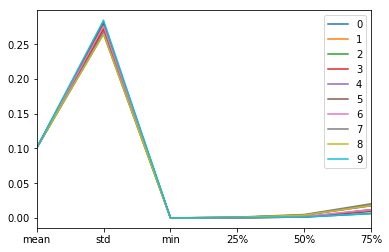

In [46]:
pd.DataFrame(predicted_logreg().T).describe().iloc[1:-1,:].plot()

In [49]:
print( np.argmax( predicted_logreg(), axis=0).shape )
np.vstack( np.argmax( predicted_logreg(),axis=0) ).shape

(5000,)


(5000, 1)

In [52]:
pd.DataFrame( np.vstack( np.argmax(predicted_logreg(),axis=0)) + 1).describe()

,0
count,5000.000000
mean,5.504000
std,2.874933
min,1.000000
25%,3.000000
50%,6.000000
75%,8.000000
max,10.000000


In [55]:
res = np.float32( ( np.vstack( np.argmax( predicted_logreg(),axis=0)) + 1 ) == ex4data1['y'] )
pd.DataFrame(res).describe()

,0
count,5000.000000
mean,0.975200
std,0.155534
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [56]:
range(1,3)

[1, 2]

In [57]:
predicted_logreg().shape

(10, 5000)

In [64]:
print(y_prob.shape); print( np.argmax( y_prob,axis=0 ).shape)

(10, 5000)
(5000,)


#### Summary for Neural Net with Multiple Layers for logistic regression (but can be extended to linear regression)

* *Load boilerplate training data:*

In [9]:
sys.path.append( os.getcwd() + '/ML' )

In [10]:
from NN import Layer, cost_functional, cost_functional_noreg, gradientDescent_step, MLP

In [11]:
# Load Training Data
print("Loading and Visualizing Data ... \n")
ex4data1 = scipy.io.loadmat('./coursera_Ng/machine-learning-ex4/ex4/ex4data1.mat')

# recall that whereas the original labels (in the variable y) were 1, 2, ..., 10, for the purpose of training a 
# neural network, we need to recode the labels as vectors containing only values 0 or 1
K=10
m = ex4data1['y'].shape[0]
y_prob = [np.zeros(K) for row in ex4data1['y']]  # list of 5000 numpy arrays of size dims. (10,)
for i in range( m):
        y_prob[i][ ex4data1['y'][i]-1] = 1
y_prob = np.array(y_prob).T.astype(theano.config.floatX)  # size dims. (K,m)

print(ex4data1['X'].T.shape)
print(y_prob.shape)

Loading and Visualizing Data ... 

(400, 5000)
(10, 5000)


In [12]:
digitsMLP = MLP(3,[400,25,10], 5000, ex4data1['X'].T, y_prob, T.nnet.sigmoid, 1., 0.1, 0.0000)

In [17]:
digitsMLP.train_model(100000)

In [18]:
digitsMLP.accuracy_log_reg()

Accuracy score : 0.991200 


0.99119999999999997

In [19]:
print( digitsMLP.Thetas[0].Theta.get_value() )
digitsMLP.Thetas[1].Theta.get_value()


[[-0.03968292  0.01570808 -0.00801071 ...,  0.05324144 -0.03536524
  -0.02519361]
 [ 0.02765682  0.02882705 -0.06191737 ..., -0.01663327  0.03339296
  -0.02493248]
 [ 0.01494016 -0.03611031  0.04792143 ...,  0.0510212  -0.00466521
  -0.00434607]
 ..., 
 [ 0.03901267 -0.03169481  0.06044593 ..., -0.0364962  -0.03772442
   0.01351396]
 [ 0.03186403  0.05424397  0.02720479 ...,  0.01087107 -0.01080637
   0.01786175]
 [ 0.06252811 -0.04008792  0.06331227 ..., -0.04469054  0.02635518
   0.04384876]]


array([[ 1.20451474,  0.83254075,  0.3577919 ,  2.09141254,  0.30367732,
         1.70919907, -0.68671805,  1.94035482,  0.6540705 , -2.20026374,
         1.0235399 , -1.10299885,  0.87818861,  2.8505857 , -2.22271323,
        -2.00406885, -2.60233808, -0.85654968, -2.76958466, -1.48524833,
        -3.17246437, -0.06278938,  0.616503  ,  3.52648425,  0.98629874],
       [ 2.60660052, -0.10535918,  1.22893441,  2.44127226, -3.89616203,
        -3.1201973 , -2.51445174,  1.34601641,  3.96324277, -2.53724122,
        -3.20322871,  0.95207882, -2.91599441, -2.66748142,  1.32648623,
         0.81661856,  1.32140303, -0.87079829, -0.53782797, -1.90582633,
         3.33778262, -0.50736022, -0.66713619, -1.36594701,  2.1127429 ],
       [-1.43893147,  1.59595168,  0.58790714,  3.8221848 ,  4.65350819,
        -2.22888541, -1.92654026, -1.48021591, -3.24884081, -2.0549016 ,
         2.35445762,  3.15103745, -1.86801529,  2.50599551, -0.51754326,
        -0.61664522, -1.13638568, -3.49592352, -0

In [20]:
digitsMLP.predicted_vals_logreg()

array([[  1.69714658e-05,   6.81859674e-05,   4.40727854e-06, ...,
          5.32231061e-03,   2.53793423e-05,   1.24584597e-06],
       [  1.01746270e-03,   4.22267512e-05,   4.14312631e-03, ...,
          2.78708263e-04,   5.46442550e-07,   2.42858031e-03],
       [  1.28256984e-03,   2.17894791e-03,   8.93946737e-04, ...,
          7.34846219e-02,   1.61182688e-04,   1.05979457e-03],
       ..., 
       [  5.44993207e-04,   4.99824178e-04,   2.40481794e-02, ...,
          1.57466289e-04,   6.36213226e-03,   3.31715518e-03],
       [  8.89896415e-04,   6.08195027e-04,   1.27942930e-03, ...,
          8.00565720e-01,   9.88285422e-01,   7.53709316e-01],
       [  9.96679068e-01,   9.98024583e-01,   9.72293377e-01, ...,
          6.17099488e-07,   1.53781421e-05,   1.62253886e-01]], dtype=float32)

In [21]:
testL1a2 = theano.function([], digitsMLP.Thetas[0].alp1 )
print( testL1a2() )
testL2a2 = theano.function([], digitsMLP.Thetas[1].al )
print( testL2a2() )


[[  1.68952462e-03   9.66312247e-04   3.05149867e-03 ...,   6.01312637e-01
    7.69796073e-02   1.04411095e-02]
 [  5.63030466e-02   3.84460762e-02   3.80754247e-02 ...,   5.98353744e-01
    2.61052395e-04   2.27537050e-04]
 [  9.90030646e-01   9.98632133e-01   9.82155979e-01 ...,   1.93933040e-01
    4.72371355e-02   2.82941740e-02]
 ..., 
 [  3.31877563e-05   3.73444600e-05   8.24407116e-03 ...,   2.87410337e-03
    5.70651256e-02   5.32165647e-01]
 [  3.52760107e-04   9.42657294e-04   9.13141354e-04 ...,   6.50500178e-01
    9.91682410e-01   3.51258606e-01]
 [  5.73539697e-02   9.71803325e-04   3.29945865e-03 ...,   6.90432638e-02
    1.61013941e-05   1.03116455e-03]]
[[  1.68952462e-03   9.66312247e-04   3.05149867e-03 ...,   6.01312637e-01
    7.69796073e-02   1.04411095e-02]
 [  5.63030466e-02   3.84460762e-02   3.80754247e-02 ...,   5.98353744e-01
    2.61052395e-04   2.27537050e-04]
 [  9.90030646e-01   9.98632133e-01   9.82155979e-01 ...,   1.93933040e-01
    4.72371355e-02   

In [33]:
[1,2,3,4,5] + [8,1,5]

[1, 2, 3, 4, 5, 8, 1, 5]

In [22]:
print( digitsMLP.y.shape )
y_cls_test = np.vstack( np.argmax( digitsMLP.y, axis=0) )
print( y_cls_test.shape )
pd.DataFrame( y_cls_test ).describe()

(10, 5000)
(5000, 1)


,0
count,5000.000000
mean,4.500000
std,2.872569
min,0.000000
25%,2.000000
50%,4.500000
75%,7.000000
max,9.000000


In [23]:
pred_y_cls_test = np.vstack( np.argmax( digitsMLP.predicted_vals_logreg() , axis=0))
print( pred_y_cls_test.shape )
pd.DataFrame( pred_y_cls_test ).describe()

(5000, 1)


,0
count,5000.000000
mean,4.499000
std,2.879315
min,0.000000
25%,2.000000
50%,5.000000
75%,7.000000
max,9.000000


In [24]:
np.mean( pred_y_cls_test == y_cls_test )

0.99119999999999997

#### Testing on MNIST, from University of Montreal, Deep Learning Tutorial, data

In [27]:
K=10
m = len(train_set[1])
y_train_prob = [np.zeros(K) for row in train_set[1]]  # list of 5000 numpy arrays of size dims. (10,)
for i in range( m):
        y_train_prob[i][ train_set[1][i]] = 1
y_train_prob = np.array(y_train_prob).T.astype(theano.config.floatX)  # size dims. (K,m)
print( y_train_prob.shape )

(10, 50000)


In [28]:
print( pd.DataFrame( y_train_prob).describe() )

           0          1          2          3          4          5      \
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean    0.100000   0.100000   0.100000   0.100000   0.100000   0.100000   
std     0.316228   0.316228   0.316228   0.316228   0.316228   0.316228   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
50%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
75%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
max     1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   

           6          7          8          9        ...          49990  \
count  10.000000  10.000000  10.000000  10.000000    ...      10.000000   
mean    0.100000   0.100000   0.100000   0.100000    ...       0.100000   
std     0.316228   0.316228   0.316228   0.316228    ...       0.316228   
min     0.000000   0.000

In [29]:
m,d= train_set[0].shape
MNIST_MTL = MLP(3,[d,25,10], m, train_set[0].T, y_train_prob, T.nnet.sigmoid, 1., 0.1, 0.00001)

In [31]:
MNIST_MTL.accuracy_log_reg()

Accuracy score : 0.095720 


0.09572

In [32]:
print( MNIST_MTL.Thetas[0].Theta.get_value() )
MNIST_MTL.Thetas[1].Theta.get_value()

[[-0.21252947  0.08412755 -0.04290283 ...,  0.07965862 -0.23788518
   0.22836781]
 [ 0.21750133 -0.28106511  0.2671701  ...,  0.05657074 -0.29780233
  -0.34037825]
 [-0.02203849  0.19995408  0.29139307 ..., -0.0802632   0.14923781
  -0.01326215]
 ..., 
 [-0.09192752  0.2681919   0.26859927 ...,  0.06894684  0.12018485
  -0.32358104]
 [-0.13953739  0.02424429 -0.20282558 ...,  0.13586117 -0.29190949
   0.01420764]
 [ 0.14536618 -0.06120829 -0.19793963 ...,  0.02141157 -0.26165357
  -0.22347094]]


array([[ 0.39743981,  0.47411704, -0.06570012, -1.42164946, -1.16744244,
        -0.44029245,  1.55344975,  0.42985651,  0.42142299,  0.34747389,
        -0.81492281, -1.56219399,  0.82000202, -0.40216985,  1.47232902,
         0.35999769,  0.68932515,  0.82125103, -0.06185548, -0.27060255,
        -0.25692338, -0.86920112, -1.25981688,  1.49232507,  0.52447045],
       [-0.45812011, -1.22509992, -1.14734924,  0.8219015 ,  0.67774659,
        -0.54277843, -0.51398909, -1.19371367,  1.41380441,  0.30840605,
        -0.11502755,  0.03701442, -0.82230645,  0.57699567,  1.3465414 ,
         0.46789521,  0.72777843, -0.74098152,  1.17320132,  0.3995336 ,
         0.79102081, -0.1648806 , -0.07733183, -1.60657287, -0.64839828],
       [-0.26341805,  1.1494323 , -0.1576034 , -0.51010013, -1.4537679 ,
        -0.32284725, -0.11438043, -0.16837011, -0.92213452, -1.61426508,
        -1.34188533, -0.43147799, -0.61895543,  1.38522243, -0.58895016,
        -0.7618435 ,  0.89010906, -0.43544725,  0

In [33]:
MNIST_MTL.predicted_vals_logreg()

array([[ 0.77596611,  0.75060475,  0.423906  , ...,  0.60422331,
         0.40988356,  0.31822193],
       [ 0.34422615,  0.67563272,  0.273395  , ...,  0.20291083,
         0.3232716 ,  0.4690749 ],
       [ 0.93080932,  0.28231877,  0.59183002, ...,  0.95939362,
         0.69641775,  0.79752219],
       ..., 
       [ 0.00841192,  0.01366395,  0.53732932, ...,  0.08155674,
         0.07537536,  0.07692103],
       [ 0.90377617,  0.96592015,  0.98436731, ...,  0.98901641,
         0.98044145,  0.9684335 ],
       [ 0.0747021 ,  0.01449165,  0.20927182, ...,  0.16606021,
         0.27188161,  0.05889074]], dtype=float32)

In [34]:
MNIST_MTL.train_model(100000)

In [35]:
MNIST_MTL.accuracy_log_reg()

Accuracy score : 0.980420 


0.98041999999999996

In [36]:
print( MNIST_MTL.Thetas[0].Theta.get_value() )
MNIST_MTL.Thetas[1].Theta.get_value()

[[-0.47362512  0.18747789 -0.09561399 ...,  0.17751911 -0.53015506
   0.50892061]
 [ 0.48472929 -0.62637842  0.5954116  ...,  0.12606943 -0.66368026
  -0.7585848 ]
 [-0.04911496  0.44561294  0.64935881 ..., -0.1788629   0.33259752
  -0.02955511]
 ..., 
 [-0.20487256  0.59768224  0.59859228 ...,  0.15364726  0.26784071
  -0.72111851]
 [-0.31096086  0.05403042 -0.45201683 ...,  0.30278146 -0.65051121
   0.03166183]
 [ 0.3239423  -0.13641159 -0.44111899 ...,  0.0477186  -0.58310646
  -0.49803132]]


array([[  7.11062133e-01,   4.57554549e-01,   9.75120664e-02,
         -5.07937050e+00,  -3.83276868e+00,   5.47499716e-01,
          7.71603918e+00,   1.36168015e+00,   3.17900872e+00,
         -2.18454540e-01,  -2.86413026e+00,  -4.37900066e+00,
         -2.17216992e+00,  -6.29720163e+00,   3.04203176e+00,
         -5.22348732e-02,   1.34919095e+00,   4.03648329e+00,
         -4.14651203e+00,  -5.77749729e+00,  -2.90662193e+00,
         -3.27267551e+00,  -4.66104698e+00,   5.65531969e+00,
          4.85670775e-01],
       [ -9.64691222e-01,  -6.14411163e+00,  -7.89063311e+00,
          2.64467096e+00,   1.46627915e+00,  -3.22474170e+00,
         -1.01905584e+00,  -1.88596475e+00,   7.01221895e+00,
          1.92705405e+00,   2.55174327e+00,   1.04782128e+00,
         -5.82779360e+00,   3.49170709e+00,   6.75916958e+00,
          2.16688132e+00,   5.75238085e+00,  -3.99549007e+00,
          1.14223826e+00,  -3.51164603e+00,   1.34314454e+00,
          3.65567946e+00,   1.13587379e-01,

In [37]:
MNIST_MTL.predicted_vals_logreg()

array([[  4.52048823e-07,   1.00000000e+00,   7.51884666e-10, ...,
          6.04108479e-08,   1.88120055e-06,   1.62847478e-08],
       [  5.50135458e-11,   3.89633271e-07,   3.38999451e-09, ...,
          7.60669491e-06,   4.72258321e-09,   7.85911197e-06],
       [  2.77830568e-05,   2.95011669e-05,   3.45770331e-06, ...,
          8.52322955e-06,   7.60071725e-02,   1.38454227e-04],
       ..., 
       [  1.52943358e-05,   1.54980810e-08,   9.39907186e-05, ...,
          7.08678338e-10,   7.70168582e-11,   4.95301133e-09],
       [  9.09049849e-11,   7.11831039e-13,   5.01017041e-07, ...,
          9.96697187e-01,   1.42343296e-02,   9.99997377e-01],
       [  1.09123675e-05,   1.50772337e-06,   9.65651736e-08, ...,
          1.19623294e-07,   9.40610245e-02,   1.57795876e-06]], dtype=float32)

Save the mode; cf. [Getting Started, DeepLearning 0.1 documentation, Loading and Saving Models](http://deeplearning.net/tutorial/gettingstarted.html)

In [38]:
import cPickle

In [40]:
save_file = open('./saved_models/MNIST_MTL_log_reg','wb')

In [41]:
for Thet in MNIST_MTL.Thetas:
    cPickle.dump( Thet.Theta.get_value(borrow=True), save_file,-1) # the -1 is for HIGHEST priority
    cPickle.dump( Thet.b.get_value(borrow=True), save_file,-1)

In [42]:
save_file.close()

In [50]:
MNIST_MTL.Thetas[0].al.set_value( valid_set[0].T.astype(theano.config.floatX) )

In [47]:
K=10
m = len(valid_set[1])
y_valid_prob = [np.zeros(K) for row in valid_set[1]]  # list of 5000 numpy arrays of size dims. (10,)
for i in range( m):
        y_valid_prob[i][ valid_set[1][i]] = 1
y_valid_prob = np.array(y_valid_prob).T.astype(theano.config.floatX)  # size dims. (K,m)
print( y_valid_prob.shape )

(10, 10000)


In [48]:
MNIST_MTL.y = y_valid_prob

In [51]:
MNIST_MTL.predicted_vals_logreg()

ValueError: dimension mismatch in args to gemm (25,784)x(784,10000)->(25,50000)
Apply node that caused the error: GpuGemm{inplace}(GpuReshape{2}.0, TensorConstant{1.0}, Theta1, al, TensorConstant{1.0})
Toposort index: 14
Inputs types: [CudaNdarrayType(float32, matrix), TensorType(float32, scalar), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), TensorType(float32, scalar)]
Inputs shapes: [(25, 50000), (), (25, 784), (784, 10000), ()]
Inputs strides: [(50000, 1), (), (784, 1), (10000, 1), ()]
Inputs values: ['not shown', array(1.0, dtype=float32), 'not shown', 'not shown', array(1.0, dtype=float32)]
Outputs clients: [[GpuElemwise{ScalarSigmoid}[(0, 0)](GpuGemm{inplace}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [53]:
theano.function([], MNIST_MTL.Thetas[0].alp1)()

ValueError: dimension mismatch in args to gemm (25,784)x(784,10000)->(25,50000)
Apply node that caused the error: GpuGemm{inplace}(GpuReshape{2}.0, TensorConstant{1.0}, Theta1, al, TensorConstant{1.0})
Toposort index: 7
Inputs types: [CudaNdarrayType(float32, matrix), TensorType(float32, scalar), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), TensorType(float32, scalar)]
Inputs shapes: [(25, 50000), (), (25, 784), (784, 10000), ()]
Inputs strides: [(50000, 1), (), (784, 1), (10000, 1), ()]
Inputs values: ['not shown', array(1.0, dtype=float32), 'not shown', 'not shown', array(1.0, dtype=float32)]
Outputs clients: [[GpuElemwise{ScalarSigmoid}[(0, 0)](GpuGemm{inplace}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [56]:
Layer1 = MNIST_MTL.Thetas[0]
Layer2 = MNIST_MTL.Thetas[1]
m = valid_set[0].shape[0]
print(m)

10000


In [60]:
a2 = T.nnet.sigmoid( T.dot( Layer1.Theta, Layer1.al) + T.tile( Layer1.b, (1,m)) )
a3 = T.nnet.sigmoid( T.dot( Layer2.Theta, a2) + T.tile( Layer2.b, (1,m)) )
valid_pred = theano.function([], a3)()
print( valid_pred.shape)

(10, 10000)


In [61]:
pd.DataFrame( valid_pred.T).describe()

,0,1,2,3,4,5,6,7,8,9
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,9.992079e-02,1.074899e-01,9.912494e-02,1.052671e-01,9.976897e-02,9.037534e-02,9.769981e-02,1.085759e-01,1.005443e-01,9.500753e-02
std,2.961449e-01,3.058113e-01,2.902825e-01,2.958724e-01,2.931867e-01,2.795904e-01,2.927824e-01,3.047731e-01,2.924316e-01,2.828876e-01
min,9.005615e-17,1.986378e-17,2.439026e-13,6.265842e-16,1.214437e-18,6.500246e-18,9.674661e-19,1.735837e-17,3.318569e-18,6.359484e-18
25%,1.320481e-09,1.788181e-09,4.365240e-07,1.482097e-07,1.504599e-09,4.772580e-09,1.436151e-10,3.032865e-09,3.319625e-08,1.242549e-08
50%,9.058250e-08,1.760941e-07,1.530497e-05,8.275158e-06,3.291525e-07,4.075375e-07,2.823017e-08,4.088125e-07,3.484185e-06,1.585515e-06
75%,1.096723e-05,3.165664e-05,5.320824e-04,4.356618e-04,3.269091e-05,3.865018e-05,6.124497e-06,8.373335e-05,2.405906e-04,2.055749e-04
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.999994e-01


In [62]:
np.mean( np.vstack( np.argmax( valid_pred,axis=0)) == np.vstack( valid_set[1] ) )

0.95340000000000003

In [63]:
X_in = T.matrix()

In [64]:
X_in.set_value( valid_set[0].T.astype(theano.config.floatX))

AttributeError: 'TensorVariable' object has no attribute 'set_value'

In [68]:
a2_giv = T.nnet.sigmoid( T.dot( Layer1.Theta, X_in) + T.tile(Layer1.b, (1,m)))
a3_giv = T.nnet.sigmoid( T.dot( Layer2.Theta, a2_giv) + T.tile( Layer2.b, (1,m)) )
valid_pred_givens = theano.function([], outputs=a3_giv, givens={ X_in: valid_set[0].T.astype(theano.config.floatX)} )

In [72]:
print( valid_pred_givens().shape )
pd.DataFrame( valid_pred_givens().T).describe()

(10, 10000)


,0,1,2,3,4,5,6,7,8,9
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,9.992079e-02,1.074899e-01,9.912494e-02,1.052671e-01,9.976897e-02,9.037534e-02,9.769981e-02,1.085759e-01,1.005443e-01,9.500753e-02
std,2.961449e-01,3.058113e-01,2.902825e-01,2.958724e-01,2.931867e-01,2.795904e-01,2.927824e-01,3.047731e-01,2.924316e-01,2.828876e-01
min,9.005615e-17,1.986378e-17,2.439026e-13,6.265842e-16,1.214437e-18,6.500246e-18,9.674661e-19,1.735837e-17,3.318569e-18,6.359484e-18
25%,1.320481e-09,1.788181e-09,4.365240e-07,1.482097e-07,1.504599e-09,4.772580e-09,1.436151e-10,3.032865e-09,3.319625e-08,1.242549e-08
50%,9.058250e-08,1.760941e-07,1.530497e-05,8.275158e-06,3.291525e-07,4.075375e-07,2.823017e-08,4.088125e-07,3.484185e-06,1.585515e-06
75%,1.096723e-05,3.165664e-05,5.320824e-04,4.356618e-04,3.269091e-05,3.865018e-05,6.124497e-06,8.373335e-05,2.405906e-04,2.055749e-04
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.999994e-01


In [78]:
np.mean( np.vstack( np.argmax( valid_pred_givens(),axis=0)) == np.vstack( valid_set[1] ) )

0.95340000000000003

In [79]:
test_pred_givens = theano.function([], outputs=a3_giv, givens={ X_in: test_set[0].T.astype(theano.config.floatX)} )

In [80]:
np.mean( np.vstack( np.argmax( test_pred_givens(),axis=0)) == np.vstack( test_set[1] ) )

0.94979999999999998

In [81]:
range(1,3)

[1, 2]

In [82]:
range(3)

[0, 1, 2]

In [83]:
range(1,3-1)

[1]

cf. [Glass Classification](https://www.kaggle.com/uciml/glass)

In [11]:
gls_data = pd.read_csv( "./kaggle/glass.csv")

In [12]:
gls_data.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [16]:
gls_data.get_values().shape

(214, 10)

In [12]:
X_gls = gls_data.get_values()[:,:-1]
print(X_gls.shape)
y_gls = gls_data.get_values()[:,-1]
print(y_gls.shape)
print( y_gls[:10])
X_gls_train = gls_data.get_values()[:-14,:-1]
print(X_gls_train.shape)
y_gls_train = gls_data.get_values()[:-14,-1]
print(y_gls_train.shape)

(214, 9)
(214,)
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
(200, 9)
(200,)


In [29]:
K=7
m = len(y_gls_train)
y_gls_train_prob = [np.zeros(K) for row in y_gls_train]  # list of 5000 numpy arrays of size dims. (10,)
for i in range( m):
        y_gls_train_prob[i][ y_gls_train[i]-1] = 1
y_gls_train_prob = np.array(y_gls_train_prob).T.astype(theano.config.floatX)  # size dims. (K,m)
print( y_gls_train_prob.shape )

(7, 200)


/home/topolo/Public/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [42]:
gls_MLP = MLP( 3, [9,8,7],200, X_gls_train.T, y_gls_train_prob, T.nnet.sigmoid, 0.01,0.05,0.0001 )

In [43]:
gls_MLP.accuracy_log_reg()

Accuracy score : 0.045000 


0.044999999999999998

In [44]:
gls_MLP.train_model(10000)

In [45]:
gls_MLP.accuracy_log_reg()

Accuracy score : 0.380000 


0.38

In [46]:
gls_MLP.predicted_vals_logreg()

array([[ 0.34978667,  0.34978667,  0.34978667, ...,  0.34978667,
         0.34978667,  0.34978667],
       [ 0.3797904 ,  0.3797904 ,  0.3797904 , ...,  0.3797904 ,
         0.3797904 ,  0.3797904 ],
       [ 0.08406211,  0.08406211,  0.08406211, ...,  0.08406211,
         0.08406211,  0.08406211],
       ..., 
       [ 0.06395678,  0.06395678,  0.06395678, ...,  0.06395678,
         0.06395678,  0.06395678],
       [ 0.04376425,  0.04376425,  0.04376425, ...,  0.04376425,
         0.04376425,  0.04376425],
       [ 0.07399232,  0.07399232,  0.07399232, ...,  0.07399232,
         0.07399232,  0.07399232]], dtype=float32)

In [47]:
gls_MLP.train_model(10000)
gls_MLP.accuracy_log_reg()

Accuracy score : 0.380000 


0.38

In [ ]:
ga

In [48]:
X_gls_test = gls_data.get_values()[-14:,:-1]
print( X_gls_test.shape )
y_gls_test = gls_data.get_values()[-14:,-1]
print( y_gls_test.shape)

(14, 9)
(14,)


In [49]:
gls_predict_on_test = gls_MLP.predict_on( 14, X_gls_test.T )

In [51]:
np.mean( np.vstack( np.argmax( gls_predict_on_test(), axis=0) ) == (y_gls_test-1) )

0.0

In [52]:
y_gls_test

array([ 7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.])

In [53]:
np.vstack( np.argmax( gls_predict_on_test(), axis=0))

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [17]:
X_sym = T.matrix()

In [33]:
rng = np.random.RandomState(1234)
Thetab1 = Layer( rng, 1, 4,3,2, al = X_sym, activation=T.nnet.sigmoid)


In [34]:
Thetab1.alp1
Thetab1.Theta.get_value().shape

(3, 4)

In [35]:
Thetab2 = Layer( rng, 2, 3,2,2, al=Thetab1.alp1, activation=T.nnet.sigmoid)


In [36]:
Thetab2.al = Thetab1.alp1

In [30]:
X_sym.shape[0]

Subtensor{int64}.0

In [31]:
T.tile( Thetab1.b, (1, X_sym.shape[0]))

Reshape{2}.0

In [42]:
test12comp = theano.function( [], outputs=Thetab2.alp1, givens={ X_sym : X42test} )

In [40]:
X42test = np.array([1,2,3,4,5,6,7,8]).reshape((4,2)).astype(theano.config.floatX)

In [43]:
test12comp()

array([[ 0.91000074,  0.91101253],
       [ 0.02431746,  0.02417665]], dtype=float32)

In [44]:
X43test = np.array(range(1,13)).reshape((4,3)).astype(theano.config.floatX)

In [45]:
X43test

array([[  1.,   2.,   3.],
       [  4.,   5.,   6.],
       [  7.,   8.,   9.],
       [ 10.,  11.,  12.]], dtype=float32)

In [46]:
test43comp = theano.function( [], outputs=Thetab2.alp1, givens={ X_sym : X43test} )

In [47]:
test43comp()

ValueError: dimension mismatch in args to gemm (3,4)x(4,3)->(3,2)
Apply node that caused the error: GpuGemm{inplace}(GpuReshape{2}.0, TensorConstant{1.0}, Theta1, <CudaNdarrayType(float32, matrix)>, TensorConstant{1.0})
Toposort index: 14
Inputs types: [CudaNdarrayType(float32, matrix), TensorType(float32, scalar), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), TensorType(float32, scalar)]
Inputs shapes: [(3, 2), (), (3, 4), (4, 3), ()]
Inputs strides: [(2, 1), (), (4, 1), (3, 1), ()]
Inputs values: ['not shown', array(1.0, dtype=float32), 'not shown', 'not shown', array(1.0, dtype=float32)]
Outputs clients: [[GpuElemwise{ScalarSigmoid}[(0, 0)](GpuGemm{inplace}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [50]:
print( type(Thetab1.al ))

<class 'theano.tensor.var.TensorVariable'>


In [52]:
lin_zlp1 = T.dot(Thetab1.Theta, Thetab1.al)+T.tile( Thetab1.b, (1,Thetab1.al.shape[1]))
a1p1 = Thetab1.g( lin_zlp1 )

In [51]:
Thetab1.al = X_sym

In [53]:
Thetab2.al = a1p1

In [54]:
lin_z2p1 = T.dot(Thetab2.Theta, Thetab2.al)+T.tile( Thetab2.b, (1, Thetab2.al.shape[1]))
a2p1 = Thetab2.g( lin_z2p1 )

In [55]:
test_gen_conn = theano.function([], outputs=a2p1, givens={ Thetab1.al : X42test })

In [56]:
test_gen_conn()

array([[ 0.91000074,  0.91101253],
       [ 0.02431746,  0.02417665]], dtype=float32)

In [57]:
test_gen_conn = theano.function([], outputs=a2p1, givens={ Thetab1.al : X43test })

In [58]:
test_gen_conn()

array([[ 0.91144621,  0.91158789,  0.91166627],
       [ 0.02425005,  0.02417867,  0.02417858]], dtype=float32)

*GPU test*

In [59]:
test_gen_conn = theano.function([], outputs=sandbox.cuda.basic_ops.gpu_from_host(a2p1), givens={ Thetab1.al : X42test })

In [60]:
test_gen_conn()

CudaNdarray([[ 0.91000074  0.91101253]
 [ 0.02431746  0.02417665]])

In [61]:
test_gen_conn = theano.function([], outputs=sandbox.cuda.basic_ops.gpu_from_host(a2p1), givens={ Thetab1.al : X43test })

In [62]:
test_gen_conn()

CudaNdarray([[ 0.91144621  0.91158789  0.91166627]
 [ 0.02425005  0.02417867  0.02417858]])

#### Summary for Neural Net with Multiple Layers for logistic regression (but can be extended to linear regression)

In [9]:
sys.path.append( os.getcwd() + '/ML' )

In [10]:
from NN import MLP

In [11]:
# Load Training Data
print("Loading and Visualizing Data ... \n")
ex4data1 = scipy.io.loadmat('./coursera_Ng/machine-learning-ex4/ex4/ex4data1.mat')

# recall that whereas the original labels (in the variable y) were 1, 2, ..., 10, for the purpose of training a 
# neural network, we need to recode the labels as vectors containing only values 0 or 1
K=10
m = ex4data1['y'].shape[0]
y_prob = [np.zeros(K) for row in ex4data1['y']]  # list of 5000 numpy arrays of size dims. (10,)
for i in range( m):
        y_prob[i][ ex4data1['y'][i]-1] = 1
y_prob = np.array(y_prob).T.astype(theano.config.floatX)  # size dims. (K,m)

print(ex4data1['X'].T.shape)
print(y_prob.shape)

Loading and Visualizing Data ... 

(400, 5000)
(10, 5000)


In [12]:
digitsMLP = MLP( 3, [400,25,10], ex4data1['X'].T, y_prob, T.nnet.sigmoid, 1.)

In [13]:
digitsMLP.build_update(ex4data1['X'].T, y_prob, 0.01, 0.00001)

In [14]:
digitsMLP.predicted_vals_logreg()

array([[ 0.01459562,  0.00558456,  0.02797613, ...,  0.0674273 ,
         0.04817105,  0.03059   ],
       [ 0.99074477,  0.97213686,  0.98990673, ...,  0.94329911,
         0.99409556,  0.98447394],
       [ 0.02927557,  0.05798027,  0.07752991, ...,  0.36027411,
         0.1559844 ,  0.26209033],
       ..., 
       [ 0.00369688,  0.01589782,  0.0115205 , ...,  0.0152018 ,
         0.00421828,  0.00280912],
       [ 0.78314799,  0.61225456,  0.71571481, ...,  0.80646819,
         0.94149739,  0.52025074],
       [ 0.96498191,  0.98687011,  0.78228015, ...,  0.95690244,
         0.63841748,  0.404479  ]], dtype=float32)

In [15]:
digitsMLP.accuracy_logreg( ex4data1['X'].T, y_prob)

Accuracy score : 0.134200 


0.13420000000000001

In [16]:
digitsMLP.train_model(10000)

In [17]:
digitsMLP.accuracy_logreg( ex4data1['X'].T, y_prob)

Accuracy score : 0.894600 


0.89459999999999995

In [18]:
digitsMLP.train_model(50000)

In [19]:
digitsMLP.accuracy_logreg( ex4data1['X'].T, y_prob)

Accuracy score : 0.956600 


0.95660000000000001

#### Testing on University of Montreal LISA lab MNIST data

In [20]:
import gzip
import six.moves.cPickle as pickle
with gzip.open("../DeepLearningTutorials/data/mnist.pkl.gz", 'rb') as f:
    try:
        train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    except:
        train_set, valid_set, test_set = pickle.load(f)

In [21]:
K=10
m = len(train_set[1])
y_train_prob = [np.zeros(K) for row in train_set[1]]  # list of 5000 numpy arrays of size dims. (10,)
for i in range( m):
        y_train_prob[i][ train_set[1][i]] = 1
y_train_prob = np.array(y_train_prob).T.astype(theano.config.floatX)  # size dims. (K,m)
print( y_train_prob.shape )

(10, 50000)


In [22]:
MNIST_MLP = MLP( 3,[784,49,10], train_set[0].T, y_train_prob, T.nnet.sigmoid, 1.)

In [23]:
MNIST_MLP.build_update( train_set[0].T, y_train_prob, 0.01, 0.0001)

In [24]:
MNIST_MLP.accuracy_logreg( train_set[0].T, y_train_prob)

Accuracy score : 0.098660 


0.098659999999999998

In [25]:
MNIST_MLP.train_model(50000)

In [26]:
MNIST_MLP.accuracy_logreg( train_set[0].T, y_train_prob)

Accuracy score : 0.862140 


0.86214000000000002

In [30]:
%time MNIST_MLP.train_model(100000)

CPU times: user 3min 38s, sys: 8min 22s, total: 12min
Wall time: 12min


In [31]:
MNIST_MLP.accuracy_logreg( train_set[0].T,y_train_prob)

Accuracy score : 0.826500 


0.82650000000000001

In [32]:
m = len(valid_set[1])
y_valid_prob = [np.zeros(K) for row in valid_set[1]]  # list of 5000 numpy arrays of size dims. (10,)
for i in range( m):
        y_valid_prob[i][ valid_set[1][i]] = 1
y_valid_prob = np.array(y_valid_prob).T.astype(theano.config.floatX)  # size dims. (K,m)
print( y_valid_prob.shape )

(10, 10000)


In [33]:
m = len(test_set[1])
y_test_prob = [np.zeros(K) for row in test_set[1]]  # list of 5000 numpy arrays of size dims. (10,)
for i in range( m):
        y_test_prob[i][ test_set[1][i]] = 1
y_test_prob = np.array(y_test_prob).T.astype(theano.config.floatX)  # size dims. (K,m)
print( y_test_prob.shape )

(10, 10000)


In [34]:
MNIST_MLP.accuracy_logreg( valid_set[0].T,y_valid_prob)

Accuracy score : 0.814200 


0.81420000000000003

In [35]:
MNIST_MLP.accuracy_logreg( test_set[0].T,y_test_prob)

Accuracy score : 0.805000 


0.80500000000000005

In [40]:
MNIST_d = train_set[0].T.shape[0]
print(MNIST_d)
MNIST_MLP = MLP( 3,[MNIST_d,25,10], train_set[0].T, y_train_prob, T.nnet.sigmoid, 1.)
MNIST_MLP.build_update( train_set[0].T, y_train_prob, 0.1, 0.00001)

784


In [41]:
MNIST_MLP.accuracy_logreg( train_set[0].T, y_train_prob)

Accuracy score : 0.095720 


0.09572

In [42]:
MNIST_MLP.train_model(150000)

In [43]:
MNIST_MLP.accuracy_logreg( train_set[0].T, y_train_prob)

Accuracy score : 0.986520 


0.98651999999999995

In [44]:
MNIST_MLP.accuracy_logreg( valid_set[0].T, y_valid_prob)

Accuracy score : 0.950600 


0.9506

In [45]:
MNIST_MLP.accuracy_logreg( test_set[0].T, y_test_prob)

Accuracy score : 0.945200 


0.94520000000000004